# WDL 2021 Final - Improving the quality of life by reducing city noise levels

## Authors

Ana Almeida &
Bruno Silva &
Carolina Alves &
Fábio Santos

## External links and resources

The data provided by the organization of the challenge can be downloaded in the following repository:

- https://github.com/anafsa/ChildrenOfJupyterDatasets/tree/main/Final/Data

We did some changes (very few) to make it easier to preprocess the files.

We used the following API to get holidays information. 

- https://calendarific.com/api-documentation

We performed the queries in the browser and downloaded the files. 

We obtained data about football games from the Italian Serie-A. The original data can be found at 

- https://www.football-data.co.uk/italym.php. 

All external data is included in the Github repository.

## Conda Environment

*Name and version version of installed libraries* 
- pandas                    1.2.4          
- numpy                     1.20.2            
- matplotlib                3.3.4             
- seaborn                   0.11.1
- keras                     2.4.3
- sklearn                   0.0
- statsmodels               0.12.2

# Introduction

Over the last years, the quality of life of urban population has received considerable attention from social scientists [1]. One of the aspects of quality of life is related to health, which according to the World Health Organization (WHO) is defined as “A state of physical, mental and social well-being, not merely the absence of disease and infirmity” [2].

Related to the health of urban population are the different types of urban pollution. Environmental noise, due to the growing number of people in cities, starts to achieve high noise levels and, as consequence, to have a negative impact on people’s lives. 

The prolonged exposure to environmental noise is associated with an increased risk of negative physical and psychological health outcomes [3]. Besides that, environmental noise is highly related to sleep disturbances in urban areas, causing immediate effects, like trouble in falling asleep, next-day effects, like irritability, and also long-term effects on mental and cardiovascular health [4]. During the day it is recommended that noise levels are kept below 65 dB, which is the measure that the WHO defined as the noise pollution threshold, and during the night, for a person to have a restful sleep, the level must drop below 30 dB [5].

According to literature, the main sources of environmental noise are road traffic, air traffic, industry, construction and nightlife [3][5]. Some of the studies carried out in this area encompass the use of sensors to monitor sound levels and also make use of other types of variables such as traffic factors, meteorological factors, number of people, city events, and special places such as pubs, restaurants and big squares [1][6][7].

With this work, we intend to detect and predict high noise levels as we believe that this is one of the approaches that allows the elaboration of more effective measures to combat noise pollution. Furthermore, with the various types of data provided, we intend to understand how noise levels vary throughout the day, week, month, and year, and also how they relate to other types of external data such as the number of people, demographical characteristics, weather, holidays, weekends, and soccer games. These analyzes are found in section 4 - Exploratory Analysis of Data (EDA).

In addition, with geographical data from sensors and the estimation area of complaints, we performed a graphical visualization of this data in an attempt to discover new patterns and to justify some of the outcomes drawn in the exploratory data analysis.

In our solution, we use two types of models: a statistical method, that is the SARIMAX, and a deep learning method, that is the Convolutional Neural Network (CNN). Both models aim to predict the mean number of high noise levels per day and test the use of variables that in EDA seemed to relate to the noise peaks.

# Data pre-processing for noise sensors data

The data provided are for several years but, for this work, only data from the years 2016, 2017, 2018, and 2019 are used. We considered that the years of 2020 and 2021, due to COVID-19, may have notable differences regarding noise levels due to a change in people's habits when comparing with the previous years and, therefore, their analysis would have to be separate. To optimize time, we did not analyze them.

In section 3.3, in order to avoid the repetition of reading the files, the dataset of selected years was previously saved in binary format to make the process faster. Thus, the function *saving_dfs_as_binary_files* can be passed.

## Import libraries and customize seaborn

In [2]:
import pandas as pd
import numpy as np
import math
import time
import datetime
import pickle
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers.convolutional import Conv1D, MaxPooling1D
#from keras.models import Sequential
#from sklearn.metrics import mean_squared_error
#from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
#import folium
#import branca
#import geopandas as gpd
#from itertools import combinations
#import re

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import json

pd.set_option('display.max_rows', 100)
sns.set_theme(style="whitegrid")
fig_dim = (16,9)

from pylab import rcParams
rcParams['figure.figsize'] = 20, 12

import warnings
warnings.filterwarnings('ignore')

base_datasets = 'Data'
base = 'Data/noise_data/csv_format'
base_sim = 'Data/sim_count'

## Auxiliar functions

In [3]:
# bar plot function
def bar_plot(_x, _y, _data):
    fig, axs = plt.subplots(figsize=fig_dim)
    axs = sns.barplot(x=_x, y=_y, data=_data)
    plt.xticks(rotation=90)
    plt.draw()
    
# performs the encoding of categorical features to ordinal numbers
def encode_categorical_features(_df, features):
    df = _df.copy()
    enc = OrdinalEncoder()
    df[features] = enc.fit_transform(df[features]).astype(int)
    
    return enc, df

def correlation_matrix (df, fig_dim):
    cor = df.corr()
    mask = np.triu(np.ones_like(cor, dtype=bool))
    fig,ax = plt.subplots(figsize=fig_dim)
    sns.heatmap(cor, mask=mask, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

## Loading the noise dataset

In [3]:
# Opening and saving the original dataset
# We converted the file from csv to binary in order to read it faster
# You do not need to run this cell
def saving_dfs_as_binary_files(base):
    
    df = pd.read_csv(base+'/'+"san_salvario_" + str(2016) + ".csv", sep=";")
    
    for year in range(2017, 2020):
        _df_year = pd.read_csv(base+'/'+"san_salvario_" + str(year) + ".csv", sep=";")
        df = pd.concat([df, _df_year])
    
    pickle.dump(df, open(base+'/'+"df_raw", "wb"))
        
saving_dfs_as_binary_files(base)

Load noise sensor data

In [4]:
sensors = ['C1', 'C2', 'C3', 'C4', 'C5']

# Opening data
def get_sensors_data(sensors):
    df = pickle.load(open(base+'/'+"df_raw", "rb" ))

    for col in sensors:
        df[col] = df[col].str.replace(',', '.').astype(float)

    df['date'] = pd.to_datetime(df["Data"] + df['Ora'] , format='%d-%m-%Y%H:00')
    df['year'] = df["date"].dt.year
    df['month'] = df["date"].dt.month
    df['day'] = df["date"].dt.day
    df['hour'] = df['Ora'].str.replace(':00', '').astype(int)
    
    df = df.set_index('date')

    # get average of noise levels
    temp = ['C1_temp', 'C2_temp', 'C3_temp', 'C4_temp', 'C5_temp']
    for i in range(len(sensors)):
        df[temp[i]] = pow(10, df[sensors[i]]/10)

    df['C_avg'] = df[temp].sum(axis = 1)\
        .div(5 - df[temp].isnull().sum(axis=1))
    df['C_avg'] = 10*np.log10(df['C_avg'])
    
    #return df
    return df[['year', 'month', 'day', 'hour', 'C1', 'C2', 'C3', 'C4', 'C5', 'C_avg']]
    
sensors_df = get_sensors_data(sensors)
sensors_df.head()

,year,month,day,hour,C1,C2,C3,C4,C5,C_avg
date,,,,,,,,,,
2016-06-01 00:00:00,2016,6,1,0,61.1,58.8,63.7,60.4,60.2,61.162532
2016-06-01 01:00:00,2016,6,1,1,57.2,56.1,60.4,57.7,58.4,58.207715
2016-06-01 02:00:00,2016,6,1,2,52.5,53.4,52.9,56.7,56.5,54.788571
2016-06-01 03:00:00,2016,6,1,3,50.6,46.6,45.7,47.9,55.6,50.951102
2016-06-01 04:00:00,2016,6,1,4,47.4,46.2,45.1,45.8,56.8,51.110268


In [5]:
sensors_df.shape

(31416, 10)

## Data types, uniques, NaNs and Zeros information 

**Checking type of data, number of unique values and the presence of missing values and zeros for sensors noise data**

In [6]:
def eda_to_df(df):
    header="+" + ("-"*112) + "+"
    form = "|{:^18s}|{:^17s}|{:^10s}|{:^10s}|{:^15s}|{:^10s}|{:^15s}|{:^10s}|"
    print(header)
    print(form.format("Column", "Type", "Uniques", "NaN?", "Number of NaN" ,"%NaN", "Number of 0s" ,"%0s"))
    print(header)
    for col in df.columns:
        print(form.format(str(col), # Column
                          str(df[col].dtypes), # Type
                          str(len(df[col].unique())), # Uniques
                          str(df[col].isnull().values.any()), # NaN?
                          str(df[col].isnull().sum()), # Number of NaNs
                          str(round(((df[col].isnull().sum())/len(df[col]))*100,5)), # %NaN
                          str((df[col] == 0).sum()), # Number of 0's
                          str(round((((df[col] == 0).sum())/len(df[col]))*100,5))) # %0's
              )
    print(header)    

eda_to_df(sensors_df)

+----------------------------------------------------------------------------------------------------------------+
|      Column      |      Type       | Uniques  |   NaN?   | Number of NaN |   %NaN   | Number of 0s  |   %0s    |
+----------------------------------------------------------------------------------------------------------------+
|       year       |      int64      |    4     |  False   |       0       |   0.0    |       0       |   0.0    |
|      month       |      int64      |    12    |  False   |       0       |   0.0    |       0       |   0.0    |
|       day        |      int64      |    31    |  False   |       0       |   0.0    |       0       |   0.0    |
|       hour       |      int32      |    24    |  False   |       0       |   0.0    |     1309      | 4.16667  |
|        C1        |     float64     |   395    |   True   |     3046      |  9.6957  |       0       |   0.0    |
|        C2        |     float64     |   362    |   True   |     2395      |  7.

Regarding the sensors, they all have NaN values. However, it should be noted that sensor 3 (C3) has the highest percentage of NaN values, with 41%, followed by sensor 4 (C4), with 21%, and sensor 5 (C5), with 12%. Sensors 1 (C1) and 2 (C2) have the lowest percentage of NaN.

Checking this, the calculation of the daily average noise level (C_avg) had to depend on the number of active sensors.

Lastly, it should be noted that although the hour column has some zero values, they represent the 0 hour (00h00) of the day (midnight) and, therefore, are not anomalies.

## Data Statistics

### General Statistics of sensor data

In [7]:
sensors_df.describe()

,year,month,day,hour,C1,C2,C3,C4,C5,C_avg
count,31416.000000,31416.000000,31416.000000,31416.000000,28370.000000,29021.000000,18433.000000,24793.000000,27494.000000,31087.000000
mean,2017.673033,6.931245,15.731856,11.500000,59.457804,58.090407,59.955498,59.422833,61.125453,60.577175
std,1.051066,3.382005,8.801526,6.922297,5.629829,5.034970,7.907549,5.063291,4.492895,5.073491
min,2016.000000,1.000000,1.000000,0.000000,32.600000,32.400000,38.500000,30.100000,33.100000,32.500000
25%,2017.000000,4.000000,8.000000,5.750000,57.600000,55.800000,55.000000,57.600000,58.900000,58.719534
50%,2018.000000,7.000000,16.000000,11.500000,60.500000,59.400000,60.400000,60.800000,62.100000,61.565931
75%,2019.000000,10.000000,23.000000,17.250000,62.500000,61.500000,64.200000,62.700000,64.100000,63.368428
max,2019.000000,12.000000,31.000000,23.000000,95.600000,80.300000,82.300000,76.800000,82.700000,88.623121


Brief analysis:
- all months, days and hours are recorded 
- the minimum noise level recorded is 30.1 dB
- the maximum noise level recorded is 95.6 dB

### Histogram

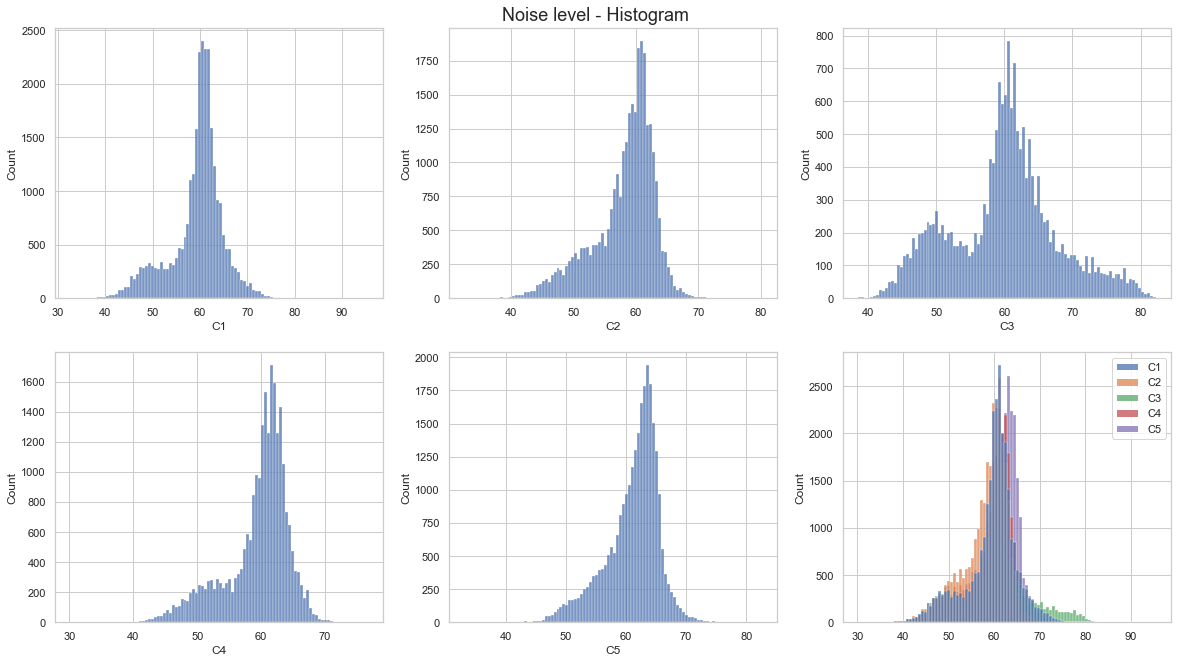

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
m = 'stack'
fd = {'fontsize': 16}
fd_l = {'fontsize': 12}

axis = [axs[0, 0], axs[0, 1], axs[0, 2], axs[1, 0], axs[1, 1], axs[1, 2]]

for i in range(6):    
    if i==5:
        sns.histplot(sensors_df[sensors], ax=axis[i],bins=100, multiple=m)
    else:
        sns.histplot(sensors_df[sensors[i]], ax=axis[i], bins=100, multiple=m)

fig.suptitle("Noise level - Histogram", size=18)
fig.subplots_adjust(top=0.95)

                                            Figure 1 - Histogram

The represented histograms for each one of the sensors, and the last one for all, allow us to verify that the distribution of noise levels is similar between sensors, with a region that stands out from the rest. Even so, the region with the highest counts for C1, C2, and C3 is centered approximately at 60 dB, while for C4 and C5 it is centered at 64 dB.

For C1, C3 and C4 there is yet another region with an increase in counts around 50 dB, followed by a decrease in 55 dB.

It should be noted that C3 is the sensor with more values in the 80 dB region, which may indicate that it is located in an area with higher peaks of noise levels.

## Plotting Noise Data

The above figures represent the evolution of noise level for each sensor over time. For all sensors, there are periods in which are not recorded values.

Text(0.5, 0.9, 'Noise Level')

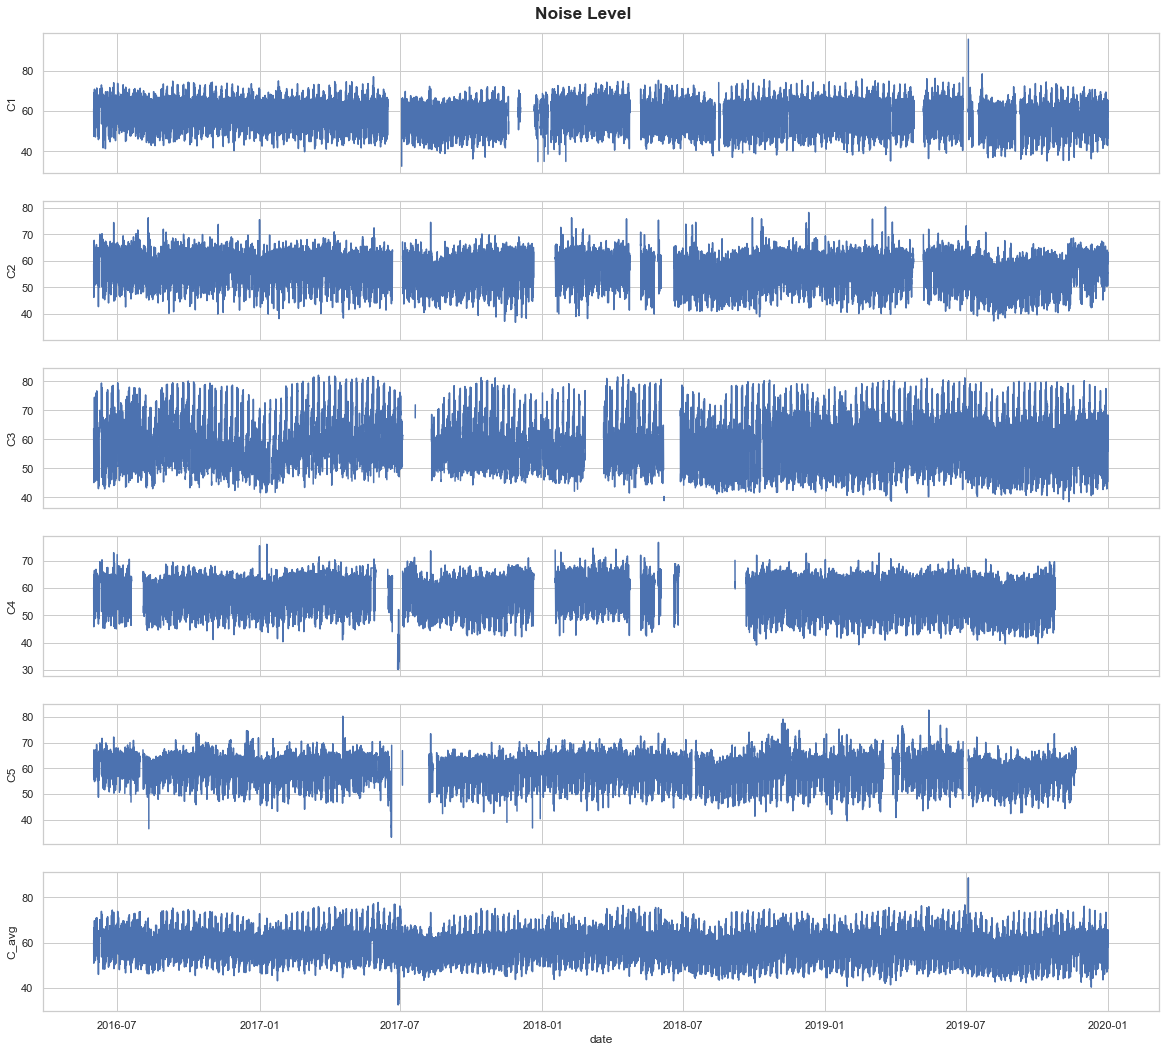

In [9]:
fig, axs = plt.subplots(6, 1, sharex=True, figsize=(20, 18))
sns.lineplot(data=sensors_df.C1, ax=axs[0])
sns.lineplot(data=sensors_df.C2, ax=axs[1])
sns.lineplot(data=sensors_df.C3, ax=axs[2])
sns.lineplot(data=sensors_df.C4, ax=axs[3])
sns.lineplot(data=sensors_df.C5, ax=axs[4])
sns.lineplot(data=sensors_df.C_avg, ax=axs[5])

fig.suptitle("Noise Level", fontsize='x-large', fontweight='bold', y=.9)

                                    Figure 2 - Evolution of noise level through time

In [10]:
last_date_c4 = sensors_df['C4'].dropna().tail(1).index.values
print("C4 - Last date with value: " + str(last_date_c4))
last_date_c5 = sensors_df['C5'].dropna().tail(1).index.values
print("C5 - Last date with value: " + str(last_date_c5))

C4 - Last date with value: ['2019-10-24T17:00:00.000000000']
C5 - Last date with value: ['2019-11-20T08:00:00.000000000']


For C4 and C5 sensors, it is verified that their acquisition ends before the end of 2019, ending for C4 in October 2019 and for C5 in November 2019.

For C_avg there is no period without monitoring, which means that every day at least one of the sensors monitored the sound levels.

# Exploratory Data Analysis

## Spatial Analysis (sensors, noise complaints and businesses)

Load the district zones in order to check which district code San Salvario belongs to.

In [11]:
gdf_zones = gpd.read_file(base_datasets+"/circoscrizioni_geo.zip")
gdf_zones.set_crs(epsg=3003, inplace=True) #original coordinate system
gdf_zones.to_crs(epsg=4326, inplace=True) #convert to the "traditional" coordinate system
gdf_zones

,NCIRCO,DENOM,geometry
0,1,Centro - Crocetta,"POLYGON ((7.65385 45.04991, 7.65489 45.05139, ..."
1,2,Santa Rita - Mirafiori,"POLYGON ((7.57787 45.04181, 7.58035 45.04427, ..."
2,3,San Paolo - Cenisia - Pozzo Strada - Cit Turin...,"POLYGON ((7.60367 45.07135, 7.60431 45.07222, ..."
3,5,Borgo Vittoria - Madonna di Campagna - Lucento...,"POLYGON ((7.61182 45.10712, 7.61264 45.10741, ..."
4,6,Barriera di Milano - Regio Parco - Barca - Ber...,"MULTIPOLYGON (((7.74046 45.11945, 7.74152 45.1..."
5,7,"Aurora, Vanchiglia - Sassi - Madonna del Pilone","POLYGON ((7.67136 45.08077, 7.67206 45.08175, ..."
6,8,San Salvario - Cavoretto - Borgo Po - Nizza Mi...,"POLYGON ((7.63602 45.02339, 7.63622 45.02355, ..."
7,4,San Donato - Campidoglio - Parella,"POLYGON ((7.60571 45.07408, 7.60575 45.07413, ..."


San Salvario belongs to the district code 8

**Load complaints dataset**


Not all of the complaints are relevant to this challenge, such as complaints regarding abandoned vehicles, vandalism or aggressions. Therefore we are only interested in complaints regarding loud noises (Rumori molesti).  
At some times, we may also be interested in complaints located in district 8 (San Salvario), which is where all sensors are located.

In [12]:
def append_to_df(df, path, xlsx=False, sep=','):
    df=pd.concat([
        df, 
        pd.read_excel(path, engine='openpyxl') if xlsx else pd.read_csv(path, sep=sep, encoding='latin-1')
    ])
    
    return df

def read_complaints(only_salvario=False):
    df_complaints=pd.read_csv('./Data/police_complaints/OpenDataContact_Gennaio_Giugno_2016.csv', sep=',')#[['Date', 'HomeTeam', 'AwayTeam']]
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Gennaio_Giugno_2016.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/Contact_Gennaio_Giugno_2017.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Luglio_Dicembre_2017.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Luglio_Dicembre_2018.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Gennaio_Giugno_2018.xlsx', xlsx=True)
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Gennaio_Giugno_2019.csv')
    df_complaints=append_to_df(df_complaints, './Data/police_complaints/OpenDataContact_Luglio_Dicembre_2019.csv', sep=';')
    
    df_complaints['Localita'] = df_complaints['Localita'].astype('str')
    df_complaints['Localita'] = df_complaints['Localita'].apply(lambda x : x.strip())
    df_complaints["Data"]=pd.to_datetime(df_complaints['Data'], utc=True).astype('datetime64[ns]')
    df_complaints["Ora"]=pd.to_datetime(df_complaints['Ora'].astype(str), utc=True, format='%H.%M').values.astype('<M8[h]')
    #Filter only by noise related complaints 
    df_complaints=df_complaints[df_complaints["Sottocategoria Criminologica"]=="Rumori molesti"]
    if only_salvario:
        df_complaints = df_complaints.loc[df_complaints['Circoscrizione'] == 8.0]
    
    return df_complaints.sort_values("Data", ascending=True) 

df_complaints = read_complaints(only_salvario=True)
df_complaints.head()

,Categoria criminologa,Sottocategoria Criminologica,Circoscrizione,Localita,Area Verde,Data,Ora
557,Convivenza Civile,Rumori molesti,8.0,MARCONI/GUGLIELMO (CORSO),NaN,2016-02-24,NaT
557,Convivenza Civile,Rumori molesti,8.0,MARCONI/GUGLIELMO (CORSO),NaN,2016-02-24,NaT
578,Convivenza Civile,Rumori molesti,8.0,GOITO/(VIA),NaN,2016-04-15,NaT
578,Convivenza Civile,Rumori molesti,8.0,GOITO/(VIA),NaN,2016-04-15,NaT
583,Convivenza Civile,Rumori molesti,8.0,GALLIARI/BERNARDINO (VIA),NaN,2016-04-22,NaT


**Load sensor locations dataset**

In [13]:
def convert_coord_to_number(coord_str):
    return float(coord_str.replace(',', '.'))

sensor_zones_df = pd.read_csv(base_datasets+"/noise_sensor_list.csv", sep=";")[['code', 'address', 'Lat', 'Long']]

sensor_zones_df['Lat'] = sensor_zones_df['Lat'].apply(lambda x : convert_coord_to_number(x))
sensor_zones_df['Long'] = sensor_zones_df['Long'].apply(lambda x : convert_coord_to_number(x))

sensor_zones_df

,code,address,Lat,Long
0,s_01,"Via Saluzzo, 26 Torino",45.059172,7.678986
1,s_02,"Via Principe Tommaso, 18bis Torino",45.057837,7.681555
2,s_03,Largo Saluzzo Torino,45.058518,7.678854
3,s_05,Via Principe Tommaso angolo via Baretti Torino,45.057603,7.681348
4,s_06,"Corso Marconi, 27 Torino",45.055554,7.682590


**Read file containing the businesses location and type**

Remove businesses whose Merchandise Type is unknown (Nessuna)

In [14]:
gdf_businesses = gpd.read_file(base_datasets+"/businesses.csv", sep=';')
gdf_businesses.set_crs(epsg=3003, inplace=True) #original coordinate system
gdf_businesses.to_crs(epsg=4326, inplace=True) #convert to the "traditional" coordinate system
gdf_businesses = gdf_businesses[gdf_businesses['Merchandise Type'] != 'Nessuna']
gdf_businesses.head(10)

,WKT,ADDRESS,OPEN YEAR,OPEN MONTH,TYPE,Description,Merchandise Type,geometry
0,POINT (1396322.217 4990301.69),VIA CLAUDIO LUIGI BERTHOLLET 24,1977,1,EXTRALIMENTARI,PICCOLE STRUTTURE,Extralimentari,POINT (7.68288 45.05840)
1,POINT (1396322.217 4990301.69),VIA CLAUDIO LUIGI BERTHOLLET 24,1985,6,ALIMENTARI,PICCOLE STRUTTURE,Panificio,POINT (7.68288 45.05840)
8,POINT (1396009.149 4990467.107),VIA CLAUDIO LUIGI BERTHOLLET 2/G,2017,3,MISTA,PICCOLE STRUTTURE,Gastronomia,POINT (7.67887 45.05985)
9,POINT (1396357.532 4990581.082),CORSO VITTORIO EMANUELE II 25/G,2017,4,EXTRALIMENTARI,PICCOLE STRUTTURE,Mobili,POINT (7.68327 45.06092)
11,POINT (1396009.149 4990467.107),VIA CLAUDIO LUIGI BERTHOLLET 2/G,2017,3,MISTA,PICCOLE STRUTTURE,Extralimentari,POINT (7.67887 45.05985)
12,POINT (1396357.532 4990581.082),CORSO VITTORIO EMANUELE II 25/G,2007,2,EXTRALIMENTARI,PICCOLE STRUTTURE,Mobili,POINT (7.68327 45.06092)
15,POINT (1396368.751 4990575.145),CORSO VITTORIO EMANUELE II 25,1989,7,EXTRALIMENTARI,PICCOLE STRUTTURE,Extralimentari,POINT (7.68342 45.06087)
16,POINT (1396022.809 4990459.897),VIA CLAUDIO LUIGI BERTHOLLET 4/C,2018,1,MISTA,PICCOLE STRUTTURE,Mista,POINT (7.67905 45.05978)
17,POINT (1396022.809 4990459.897),VIA CLAUDIO LUIGI BERTHOLLET 4/C,2016,5,ALIMENTARI,PICCOLE STRUTTURE,Alimentari,POINT (7.67905 45.05978)
18,POINT (1396342.72 4990588.919),CORSO VITTORIO EMANUELE II 27/C,1986,11,EXTRALIMENTARI,PICCOLE STRUTTURE,Extralimentari,POINT (7.68309 45.06099)


In [15]:
unique_adresses = gdf_businesses.ADDRESS.unique()

**Group the number of complaints by local**

In [16]:
df_complains_by_local = df_complaints.groupby("Localita").size().reset_index(name='complaint_count')
df_complains_by_local.head()

,Localita,complaint_count
0,AMADEO/G. ANTONIO (VIA),1
1,ARGENTERO/GIOVANNI (VIA),1
2,ASTI/(VIA),1
3,BARETTI/GIUSEPPE (VIA),1
4,BELFIORE/(VIA),6


Businesses dataset presents a full address, but complaints only a road. We would like to get road coordinates but we could not find this information, so instead we try to associate the roads in the complaints with the addresses of businesses. This allows us to have an estimated location of where the compltain took place

In [17]:
#helper function to assign roads into more specific addresses.
def search_address(address):
    key_words = re.split(r'[\s+\(\)/,;]+', address)
    key_words = set(key_words)
    if "VIA" in key_words:
        key_words.remove("VIA")
    if "CORSO" in key_words:
        key_words.remove("CORSO")
    if "" in key_words:
        key_words.remove("")
    ratio = 0
    matched_addr=""
    for adr in unique_adresses:
        adr_words = re.split(r'[\s+\(\)/,;]+', adr)
        adr_words = set(adr_words)
        r = 0
        for word in key_words:
            if word in adr_words:
                r +=1
        if r > ratio:
            matched_addr = adr
    return matched_addr

#search_address("BARETTI/GIUSEPPE (VIA)") #Test

In [18]:
def add_coords(local):
    address = search_address(local)
    if address != "":
        #get coordinate of address
        c = gdf_businesses.loc[gdf_businesses['ADDRESS'] == address, 'geometry'].iloc[0]
        return (c.y, c.x)

#build a dataframe with road and a coordinate on that road (taken from a businesses in that road)
df_complains_by_local['coords'] = df_complains_by_local.apply(lambda x: add_coords(x['Localita']), axis=1)
df_complains_by_local.head()

,Localita,complaint_count,coords
0,AMADEO/G. ANTONIO (VIA),1,None
1,ARGENTERO/GIOVANNI (VIA),1,None
2,ASTI/(VIA),1,None
3,BARETTI/GIUSEPPE (VIA),1,"(45.0575352701371, 7.681219625833094)"
4,BELFIORE/(VIA),6,"(45.05910054446746, 7.680404960837597)"


We will now visualize the sensor's positions in a map, as well as the sinalize the locations of some of the complaints in order to get more conclusions. This type of analysis can reveal useful information such as why certain zones have more complains than others. It is also useful to understand how the sensors are spatially situaded: are they too close to each other or very far?  
We did not added business data on the map because OpenSteetMap already has a few of this information visible on the map, but also because it would be harder to read the map.

Black Markers represent the censors. Click on them to see their name and their address.  
Markers with a "megaphone" icon represent an estimate location of complaints registered in that road between 2016 and 2019. The color indicates the number of complaints registered. Click on a marker to see their number of complaints.

In [19]:
#assign colors to the number of complains
dic_category_colors = {
    1: 'blue',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'red',
    6: 'darkred'
}

m=folium.Map(location=[45.05801, 7.68204], zoom_start=16) #initialize map at San Salvario

def add_marker(title, descr, lat, long, group, color, icon):
    folium.Marker(location=[float(lat), float(long)], popup="<html>"+title+"<br/>"+descr+"</html>",
                 icon=folium.Icon(color=color, icon=icon)).add_to(group)
    
def add_circle_mark(title, descr, n, coords, group):
    if coords == None:
        return
    folium.Marker(location=[coords[0], coords[1]], popup="<html>"+title+"<br/>"+descr+"</html>",\
                icon=folium.Icon(color=dic_category_colors[n], icon='volume-up')).add_to(group)
    
comp_group = folium.FeatureGroup('Markers - complains')
comp_group.add_to(m)
#bus_group = folium.FeatureGroup('Markers - businesses')
#bus_group.add_to(m)
sens_group = folium.FeatureGroup('Markers - sensors')
sens_group.add_to(m)

    
#gdf_businesses.apply(lambda l: add_marker("type: "+l['Merchandise Type'], "", l.geometry.y, l.geometry.x, 
#                                          bus_group, 'grey','usd'),axis=1)
#add sensor data
sensor_zones_df.apply(lambda l: add_marker("sensor code: "+str(l['code']), l['address'], l.Lat, l.Long, 
                                           sens_group, 'black', 'hdd'),axis=1)

                                 
#add complaint data
df_complains_by_local.apply(lambda l: add_circle_mark("Address: "+str(l['Localita']), "Nº complains: "+
                           str(l['complaint_count']), l['complaint_count'], l.coords, comp_group),axis=1)

#draw the districts zones on the map
#adapted from: https://geopandas.readthedocs.io/en/latest/gallery/polygon_plotting_with_folium.html
for _, r in gdf_zones.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, name=r['DENOM'],
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup("zone code: "+str(r['NCIRCO'])+"\ndistrict: "+r['DENOM']).add_to(geo_j)
    geo_j.add_to(m)

folium.LayerControl().add_to(m)
#add legend
legend_html = '''
{% macro html(this, kwargs) %}
<div style="
    position: fixed; 
    bottom: 180px;
    left: 20px;
    width: 120px;
    height: 80px;
    z-index:9999;
    font-size:14px;
    ">
    <p><b>Noise complaints marker colors:</b></p>
    <p><a style="color:'''+str(dic_category_colors[1])+''';font-size:120%;margin-left:20px;">&#9679;</a>&emsp;'''+str(1)+'''</p>
    <p><a style="color:'''+str(dic_category_colors[2])+''';font-size:120%;margin-left:20px;">&#9679;</a>&emsp;'''+str(2)+'''</p>
    <p><a style="color:'''+str(dic_category_colors[3])+''';font-size:120%;margin-left:20px;">&#9679;</a>&emsp;'''+str(3)+'''</p>
    <p><a style="color:'''+str(dic_category_colors[4])+''';font-size:120%;margin-left:20px;">&#9679;</a>&emsp;'''+str(4)+'''</p>
    <p><a style="color:'''+str(dic_category_colors[5])+''';font-size:120%;margin-left:20px;">&#9679;</a>&emsp;'''+str(5)+'''</p>
    <p><a style="color:'''+str(dic_category_colors[6])+''';font-size:120%;margin-left:20px;">&#9679;</a>&emsp;'''+str(6)+'''</p>
</div>
<div style="
    position: fixed; 
    bottom: 8px;
    left: 20px;
    width: 112px;
    height: 280px; 
    z-index:9998;
    font-size:14px;
    background-color: #ffffff;
    opacity: 0.7;
    ">
</div>
{% endmacro %}
'''
legend = branca.element.MacroElement()
legend._template = branca.element.Template(legend_html)
m.get_root().add_child(legend)

m

                                    Figure 3 - Map of noise complains

Regarding sensors, we can see that there are 2 pairs of sensors that are very close: 
 - Sensor s_02 (C2) and s_05 (C4), meaning that they can intercept similar levels of noise - coffes and restaurants are near these sensors
 - Sensor s_01 (C1) and s_03 (C3), although not as close as the previous pair. Restaurants are near these sensors
 - Sensor s_06 (C5) is separated from the remaining. Appears to be on larger road, meaning that more noise may be detected  
 
This is important and we will take the sensor's position into consideration for our analysis.

We intended to analyze the locals where complaints are registered and analyze which businesses appear near that place, however the data containing businesses presents a full address, but complaints only a road. We could not find road coordinates, so we tried to add markers on the map with complaints placed on top of business in the same road as the complain, however, the markers are only an estimate, as the complain may have happened in another place in the road.

It is still possible to see that in all roads where there is a record of complaints, there are establishments such as bars, restaurants, hotels, and bars which may be responsible to generate higher noises. However we cannot draw a strong enough conclusion as we don't have a specific location of the complaint.

Looking at the histogram of Figure 1 we noted that sensor C3 recorded the higher noise level. Comparing to its location in Figura 3 and the nearby buildings, it was verified that there was a bike shop and a restaurant. Although the other sensors are also nearby restaurants and coffee shops, the restaurants near C3 may be bigger, busier, and more popular.

Regarding sensor C5, it was expected that it recorded the highest noise levels due to being near to a lot of restaurants, however, that was not verified. The street where C5 is located has lots of trees, this can be the explanation for not recording the high levels of noise because trees absorb the noise [26].

**Checking which district has the most noise complaints**

In [20]:
#complaints for all districts
df_complaints = read_complaints(only_salvario=False)

Text(0, 0.5, 'District Code')

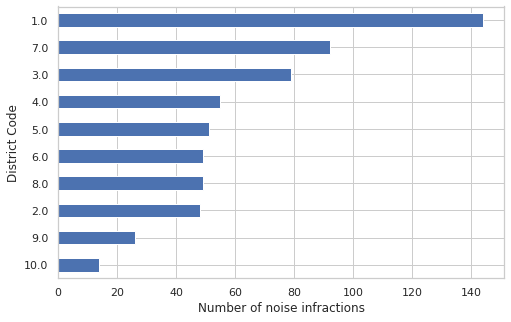

In [21]:
ax = df_complaints.Circoscrizione.value_counts().sort_values().plot(kind = 'barh', figsize=(8,5))
ax.set_xlabel("Number of noise infractions")
ax.set_ylabel("District Code")

                     Figure 4 - District code versus Number of noise infractions

District 1, located at the center of the city has the most complaints accross all years. 

## Correlation between sensors

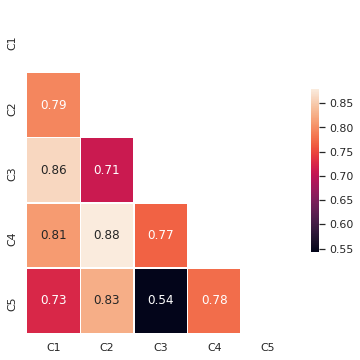

In [22]:
correlation_matrix(sensors_df[sensors], (6,6))

                     Figure 5 - Correlation matrix between the noise sensors data

Through the correlation between sensors, it is already possible to verify that there are highly correlated sensors.

Starting with sensor C1, the sensor it correlates most with is sensor C3, and vice versa. When inspecting the location of each of these sensors, it was found that geographically they are very close, which justifies the high correlation between them.

Another very notable correlation is between C4 and C2. Again, when observing the location of each one, it was verified highest proximity between them and is why they are so correlated.

Sensor C5 is the one that least relates to the rest but still has a high correlation with C2 and C4, that is the pair of sensors neraby C5 as seen in Figure 3.

Overall, all sensors are highly correlated and one explanation for this is that, despite being grouped, they are located a few blocks from each other and in addition they can all be placed near areas with the same type of movement, justifying the correlation.

## Autocorrelation Plot

Autocorrelation compares the time series with itself (at different time points) in order to find the lags that are more correlated with each other. [8]

Note that the way the lags are compared is by shifting the time series. As time goes by, there are fewer values to compare, and, therefore, the correlation value is expected to decrease over time.

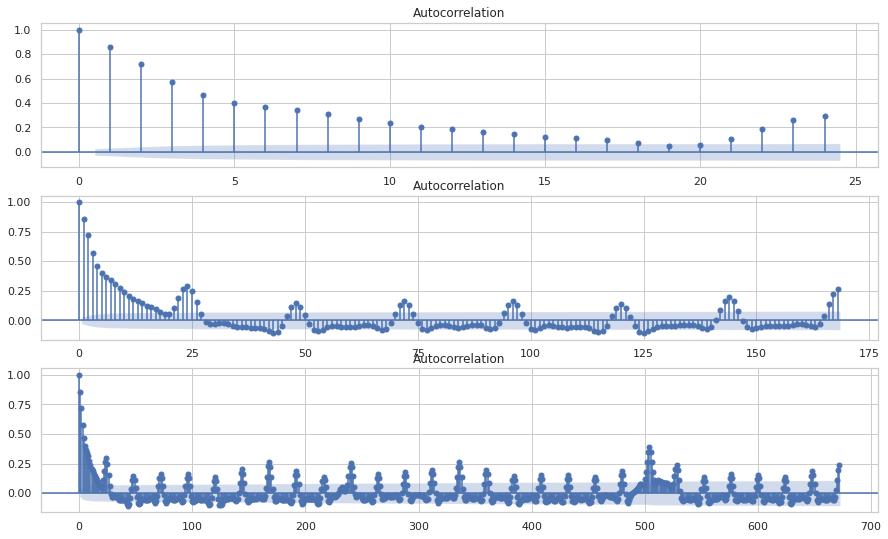

In [23]:
def autocorrelation(df, ps):
    
    df = df.fillna(0)
    
    fig, ax = plt.subplots(len(ps), 1, figsize=(15, 3*len(ps)))
    for i in range(len(ps)):
        plot_acf(df.tolist(), lags=ps[i], ax=ax[i])
        
autocorrelation(sensors_df[(sensors_df.year==2016)].C1, [24, 24*7, 24*7*4])

                  Figure 6 - Autocorrelation plot for sensor C1 in 2016

The above figure represents the different autocorralation analysis for the year of 2016.

It is analyzed that:
- in the first plot, we have the first 24 lags (1 day). The autocorrelation value goes down and then starts to increase reaching the maximum in 24h.
- in the second plot, we see that this pattern repeats itself again, and we have the maximums in multiples of 24 (after one day, two days...).
- in the 3rd plot, we see that this pattern is repeated throughout the month, and it is possible to observe higher peaks corresponding to the lags of each week.

                                                24*7 = 168
                                                24*14 = 336
                                                24*21 = 504

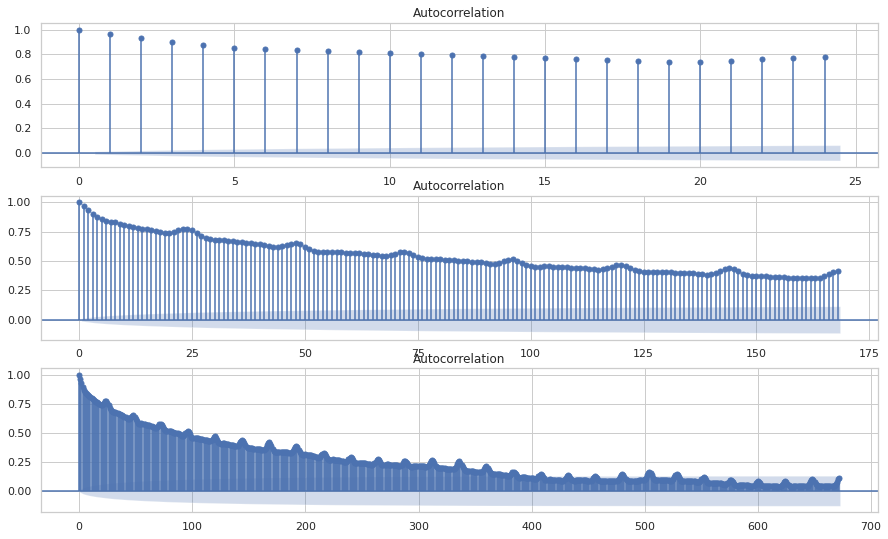

In [24]:
autocorrelation(sensors_df.C1, [24, 24*7, 24*7*4])

                  Figure 7 - Autocorrelation plot for sensor C1 from 2016 to 2019

In this figure, the autocorrelation analysis is for all years (2016-2019) and although it is less noticeable as in the previous Figure 6 because there is more data, the verified patterns are present.

## Seasonal decompose

Given the presence of zeros, the additive decomposition is performed instead of the multiplicative. This decomposition divides data into three componentes: trend, seasonal and resid.

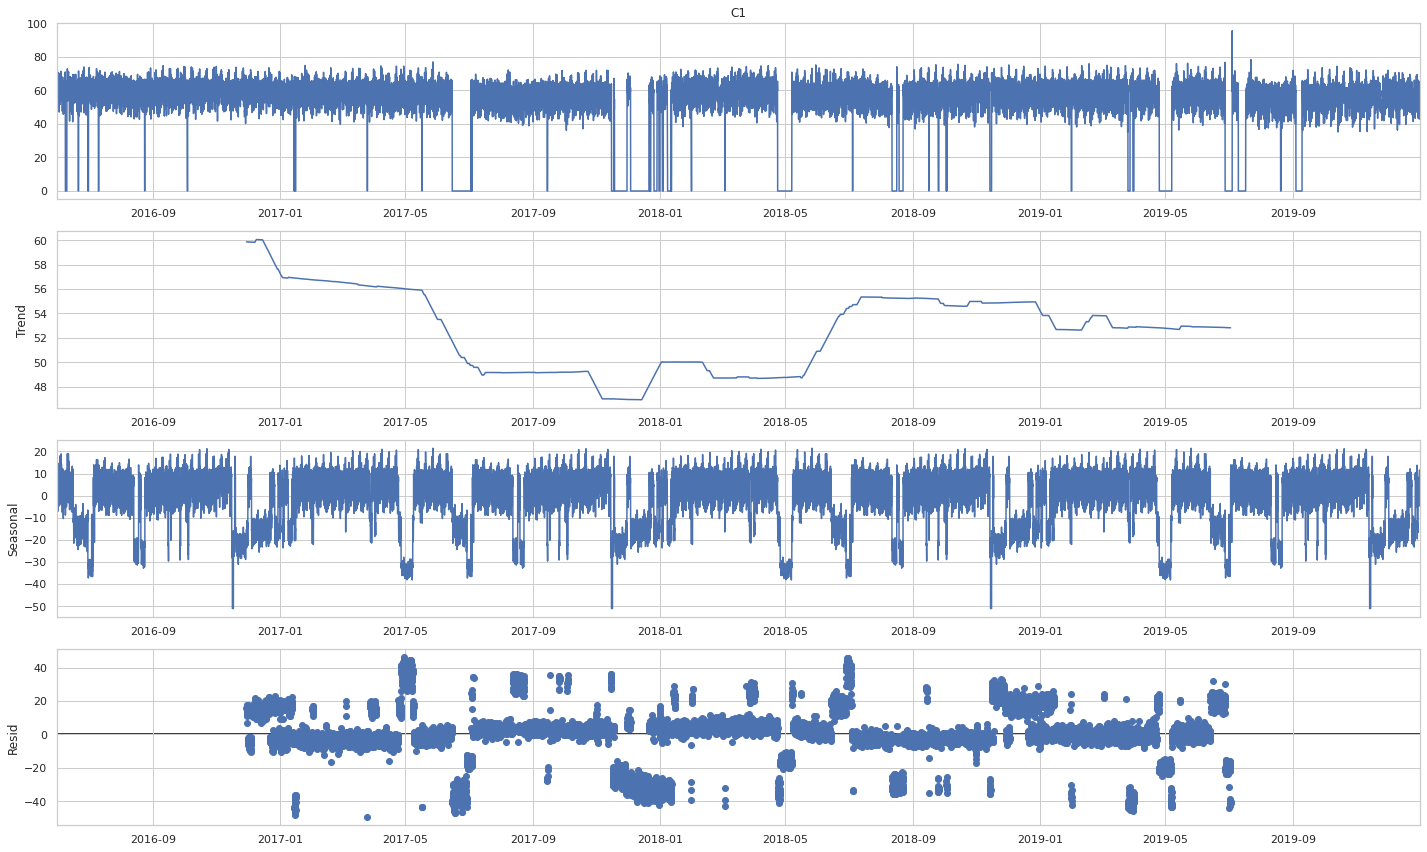

In [25]:
def ts_seasonal_decompose(df, ps):
    
    df = df.fillna(0)

    for p in ps:
        decomposition = seasonal_decompose(df, model='additive', period=p)
        decomposition.plot()
        
ts_seasonal_decompose(sensors_df.C1, [24*7*52]) # 24hours*7days*52weeks

                        Figure 8 - Seasonal decompose plot for sensor C1

By analyzing all data for sensor 1, we were able to visualize the existence of seasonal patterns (daily, weekly, monthly and annual) captured by the trend component.

The trend decreases and then increases again, however this may be due to the fact that sensor failures have increased.

**When considering data only for one year, the results are the following:**

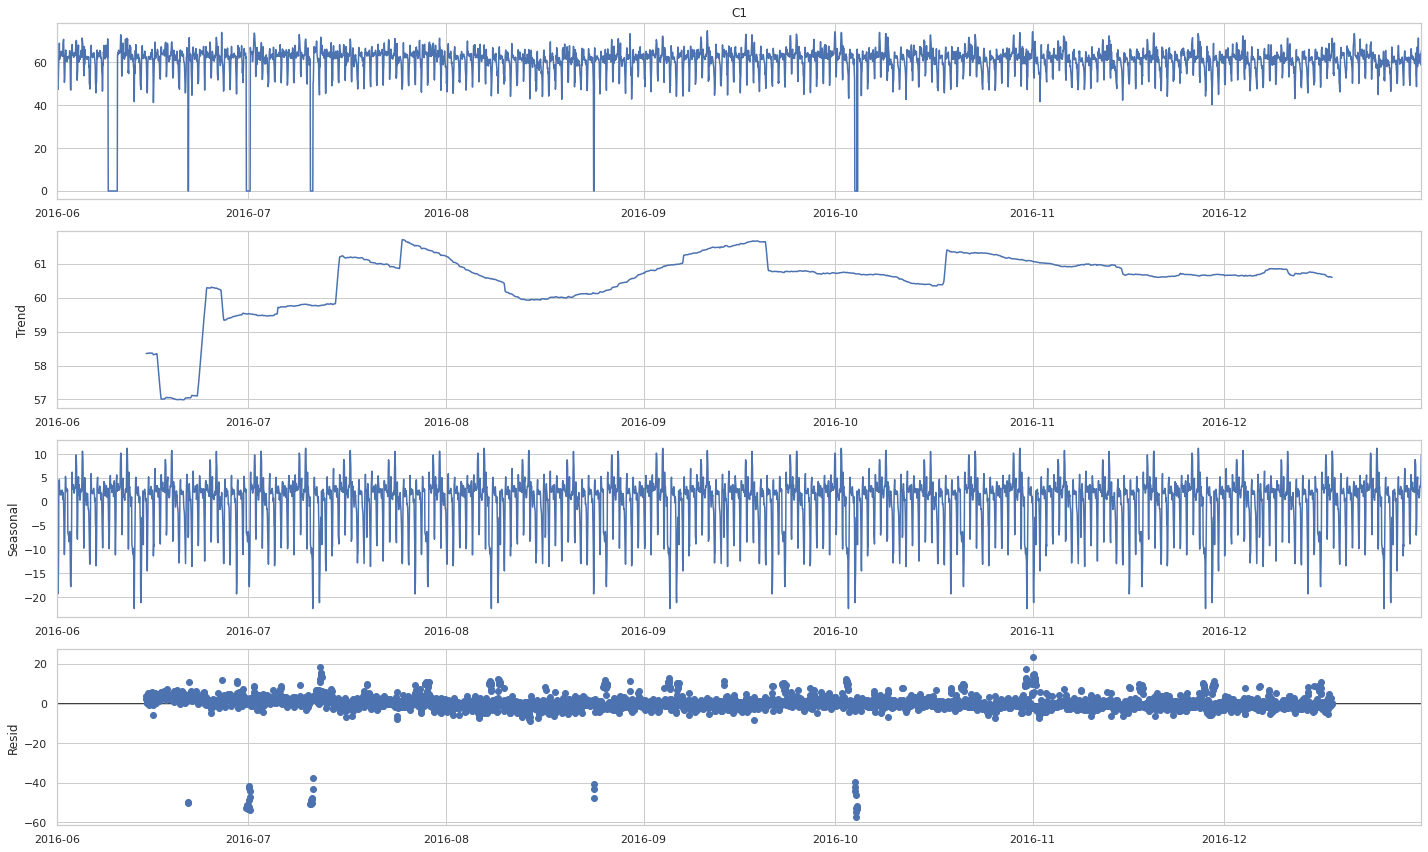

In [26]:
ts_seasonal_decompose(sensors_df[sensors_df.year==2016].C1, [24*7*4])

                  Figure 9 - Seasonal decompose plot for sensor C1 for 2016

Through the analysis of the Figure 9, it is visible the existence of patterns and usually with a crescent trend.

## Moving Average

<AxesSubplot:xlabel='date'>

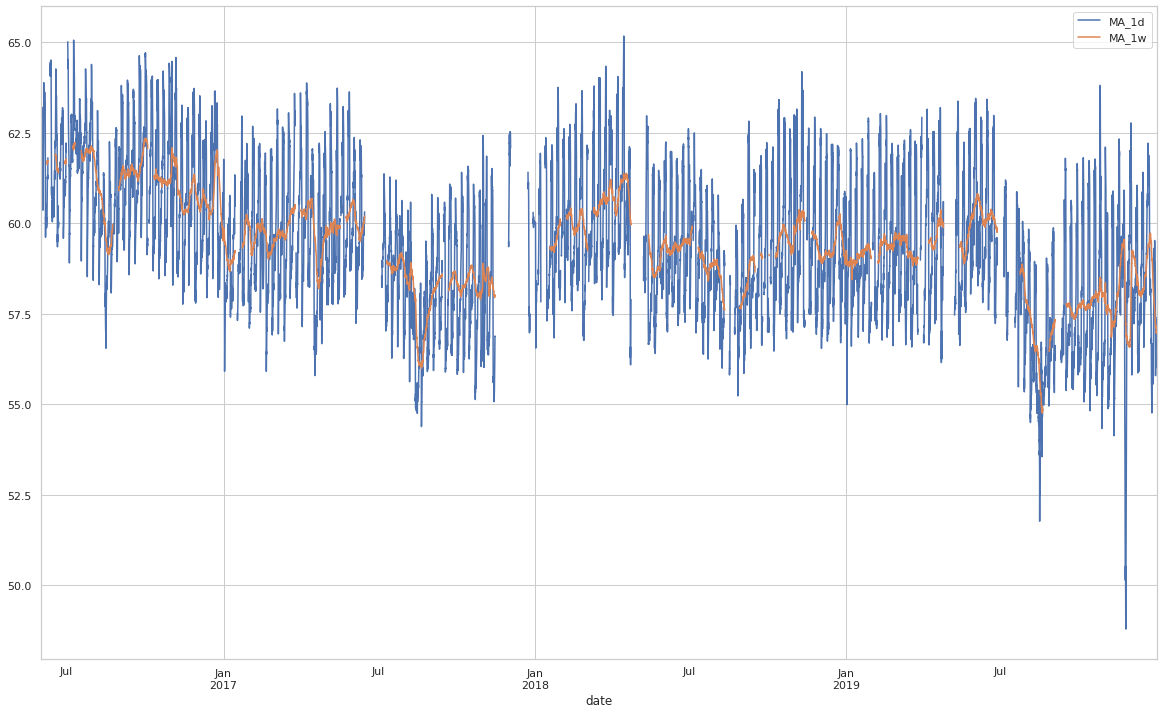

In [27]:
sensors_df['MA_1d'] = sensors_df['C1'].rolling(window=24).mean()
sensors_df['MA_1w'] = sensors_df['C1'].rolling(window=24*7).mean()

sensors_df[['MA_1d', 'MA_1w']].plot()

                             Figure 10 - Moving average for sensor C1

The figure above, after applying the moving average, represents the average evolution of noise levels over time.

In a monthly analysis, it appears that in August there is a decrease in noise levels, followed by an increase corresponding to September and October. Regarding January, when compared to the previous and following month, it is also characterized by a decrease in noise.

## Outlier Detection 

The selected approach to detect outliers was z-score [9], however, there are other types of methods such as Median Absolute Deviation [10] and Boxplot Rule [11]. The z-score was adapted to the context of our problem and since we are only interested in detecting excessive noise, we decided to only consider z-score values that positively exceed the mean.

### Using Z-Score for excessive noise detection

In [28]:
def outlier_detection_using_z_score(df, t=1, sensor='C1'):
    # t - threshold - number of standard deviation
    mean = np.mean(df.iloc[:, 0])
    std = np.std(df.iloc[:, 0])
 
    # não fazemos abs((i-mean)/std) porque só nos interessa os que estão acima da média
    df['z_score'] = [(i-mean)/std for i in df.iloc[:, 0]]
    df['is_outlier'] = [1 if x>t else 0 for x in df.z_score.values ]
 
    df['out'] = df[sensor] * df['is_outlier']
    df['out'] = [None if x==0 else x for x in df.out.values]
 
    df = df.reset_index()
 
    return df
 
df_out = outlier_detection_using_z_score(sensors_df[['C1']],1)
df_out
 
def get_avg_number_outliers(df, sensors):
 
    l_c_out = []
 
    for sensor in sensors:
        c_out = outlier_detection_using_z_score(df[[sensor]], 1, sensor).set_index('date')[['is_outlier']]
        c_out = c_out.rename(columns={'is_outlier': sensor + '_is_outlier'})
        l_c_out.append(c_out)
 
    df_tot = pd.concat(l_c_out, axis=1)
    df_tot = df_tot.resample('1D').sum()
    df_tot['mean_is_outlier'] = df_tot.mean(axis = 1)
 
    return df_tot


df_outliers_avg = get_avg_number_outliers(sensors_df, sensors)
df_outliers_avg

,C1_is_outlier,C2_is_outlier,C3_is_outlier,C4_is_outlier,C5_is_outlier,mean_is_outlier
date,,,,,,
2016-06-01,3,10,1,2,6,4.4
2016-06-02,3,1,4,2,1,2.2
2016-06-03,4,4,3,1,2,2.8
2016-06-04,8,5,5,4,4,5.2
2016-06-05,5,1,4,4,0,2.8
...,...,...,...,...,...,...
2019-12-27,1,0,1,0,0,0.4
2019-12-28,2,2,4,0,0,1.6
2019-12-29,3,0,4,0,0,1.4


In [29]:
print("Number of outliers detected: " + str(df_out['is_outlier'].sum()))

Number of outliers detected: 2971


### Visualizing the excessive noise detected

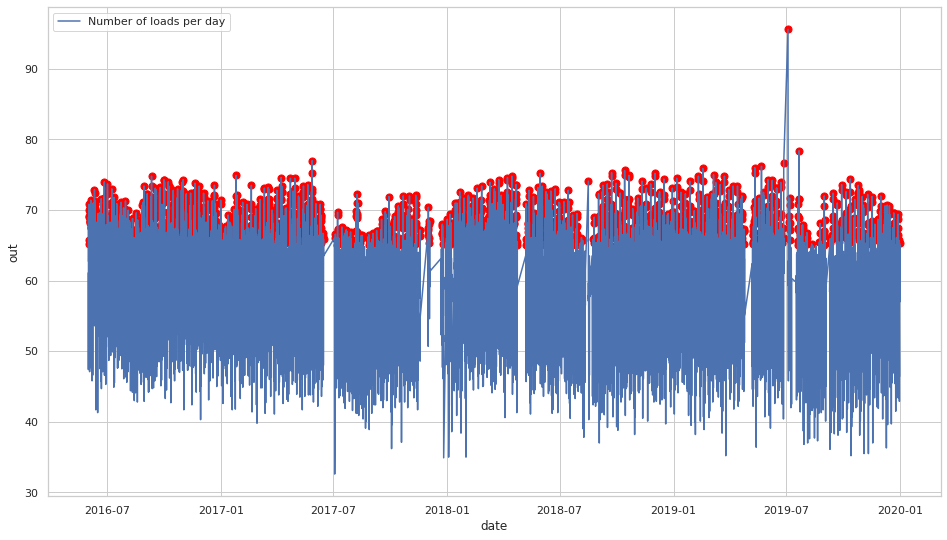

In [30]:
def plot_outliers(df):
    fig, ax = plt.subplots(figsize=fig_dim)

    sns.lineplot(data=df, x='date', y='C1', ax=ax, label="Number of loads per day")
    sns.regplot(data=df, x='date', y="out", fit_reg=False, 
                scatter_kws={"color":"red","alpha":1,"s":50}, ax=ax, label='Holidays')
    
plot_outliers(df_out)

                Figure 11 - Outlier detection using the z-score adaptation for sensor C1

For the detection of noise peaks, a standard deviation threshold of one in the z-score was considered and the peaks with values above 64 dB were detected, which match the threshold of 65 dB defined by the WHO for noise pollution.

## External Data

### SIM data

In [11]:
# Opening SIM counts
janudf = pd.read_csv(base_sim+'/'+"SIM_count_15_210118.csv", sep=";") # january
marchdf = pd.read_csv(base_sim+'/'+"SIM_count_19_250318.csv", sep=";") # march
junedf = pd.read_csv(base_sim+'/'+"SIM_count_04_100618.csv", sep=";") #junedf

# SIM counts for 2018
peopledf = pd.concat([janudf, marchdf, junedf]).reset_index().drop(columns='index')
peopledf['data_da'] = pd.to_datetime(peopledf['data_da'], format='%Y-%m-%d %H:%M:%S.%f')
peopledf['Hour'] = peopledf['data_da'].dt.hour
peopledf['Date'] = peopledf['data_da'].dt.date
peopledf['Month'] = peopledf['data_da'].dt.month

In [12]:
# Noise level for 2018
noisedf = sensors_df.copy().reset_index()
noisedf['Date'] = noisedf['date'].dt.date
noisedf = noisedf.rename(columns={'hour':'Hour','month':'Month'})

#### Number of People per demographic characteristics

In [13]:
NPdf = pd.merge(noisedf, peopledf, on=['Date','Month','Hour'])
NPdf = NPdf[['Date','Month','Hour','C_avg','cluster','numero_presenze']].rename(columns={'cluster':'Demo_of_people',
                                                                             'numero_presenze':'Number_of_people'})

In [14]:
NP_D = NPdf[['Demo_of_people','Number_of_people']].groupby(['Demo_of_people']).sum().reset_index()
NP_D.sort_values('Number_of_people', ascending=False).head(10)

,Demo_of_people,Number_of_people
12,Presenze,1674986
9,Italiani,1608453
7,Consumer,1411502
13,Residenti,991967
10,Maschi,900479
8,Femmine,774506
5,>60 anni,510412
0,18-30 anni,342978
16,Visitatori Intraregionali,315489
3,51-60 anni,302091


According to the description of demographic variables and relationships between them, provided in the challenge description, some variables were discard from this analysis because represent repeated information. The variables: Presenze (P), Italiani (NI) and Consumer (TC), depend on other variables so the following analysis won't consider them.

<AxesSubplot:xlabel='Demo_of_people', ylabel='Number_of_people'>

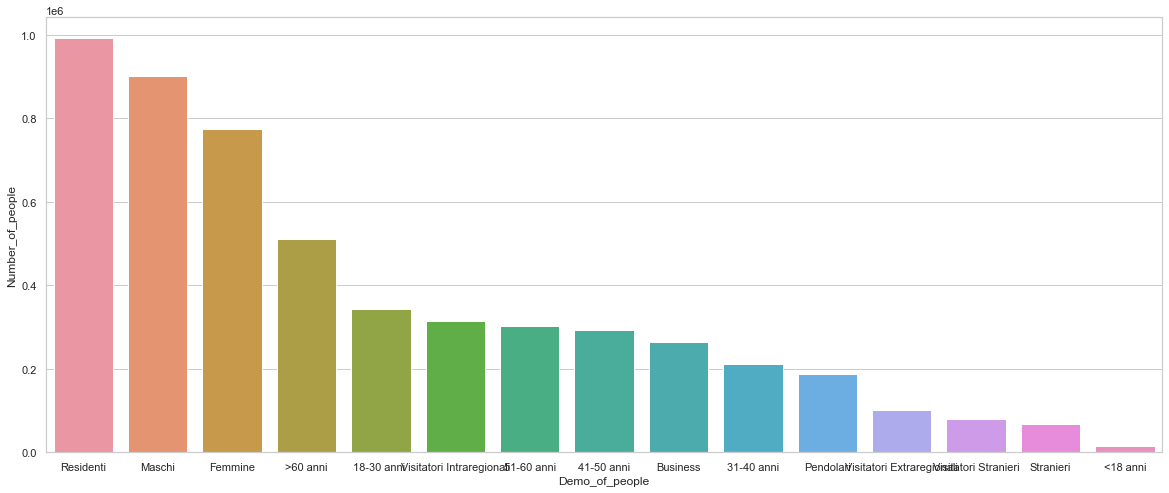

In [15]:
NP_D = NP_D[(NP_D['Demo_of_people'] != 'Presenze') & 
            (NP_D['Demo_of_people'] != 'Italiani') & (NP_D['Demo_of_people'] != 'Consumer')].sort_values('Number_of_people',
                                                                                                        ascending=False)
fig, axs = plt.subplots(figsize=(20,8))
sns.barplot(x='Demo_of_people', y='Number_of_people', data=NP_D)

                  Figure 12 - Total number of people of each demographic characteristic

Regarding age groups, the one with the highest number of people in the area is the >60 years old group, followed by the 18-30, the 51-60, and the 41-50 years old groups.

As for gender, the male gender has the greater number of people but the difference for the female is not very significant.

Another analysis is regarding the type of visitors: resident (Residenti), commuter (Pendolari), foreigner (Stranieri), extra-regional (Extraregionali), or intra-regional (Intraregionali). The type of visitors with the highest number of people is the resident, as expected, and the second is the intra-regional visitors, with a considerable difference of around 700,000 people. Then, come the commuters, the extra-regional visitors, and foreigners.

#### Noise pollution vs Number of People

In [16]:
N_NP = NPdf[['C_avg','Number_of_people']].groupby(['C_avg']).mean().reset_index() # mean number of people per day and hour

<AxesSubplot:xlabel='Number_of_people', ylabel='C_avg'>

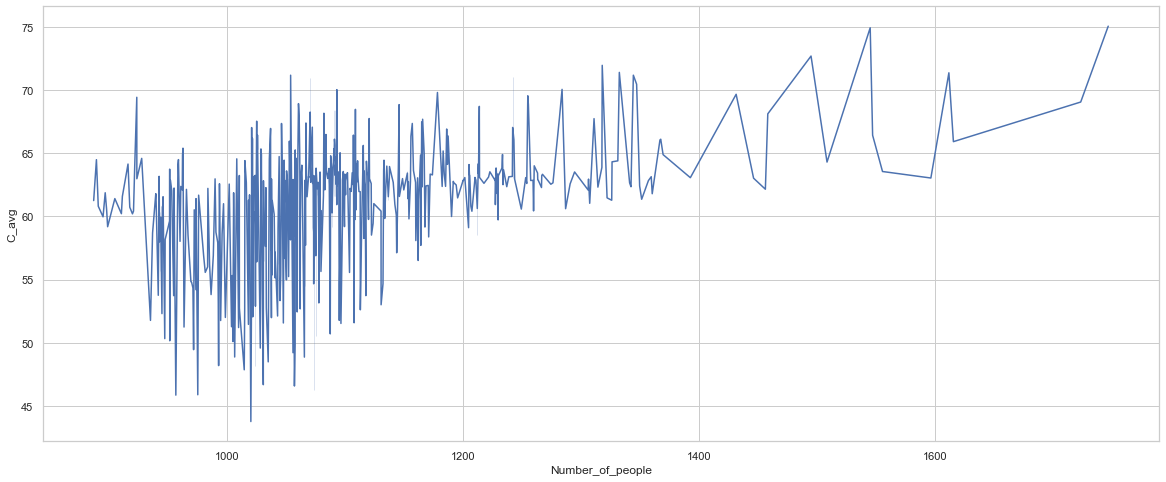

In [17]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(data=N_NP, x="Number_of_people", y="C_avg", ax=ax)

                  Figure 13 - Number of people versus noise level average

In Figure 13, in which the level of noise (dB) is represented with number of people per day and hour, it can be noticed that the higher the number of people, the higher the noise levels.

#### Noise vs Demographic Characteristics

In [18]:
N_D = NPdf.copy()
N_D = N_D[(N_D['Demo_of_people'] != 'Presenze') & 
            (N_D['Demo_of_people'] != 'Italiani') & (N_D['Demo_of_people'] != 'Consumer')]

In [19]:
def noise_groups (df, mini, maxi):
    ND = df[(df['C_avg']<maxi) & (df['C_avg']>=mini)]
    ND = ND[['Demo_of_people','Number_of_people']].groupby(['Demo_of_people']).mean().reset_index() # mean number of people 
                                                                                                    #per day and hour    
    total = ND[ND['Demo_of_people']=='Visitatori Intraregionali'].iloc[0,1] +\
            ND[ND['Demo_of_people']=='Visitatori Extraregionali'].iloc[0,1] +\
            ND[ND['Demo_of_people']=='Pendolari'].iloc[0,1] +\
            ND[ND['Demo_of_people']=='Visitatori Stranieri'].iloc[0,1]
    
    ND = ND.append({'Demo_of_people':'Total Visitors','Number_of_people':total},ignore_index=True)
    ND = ND.sort_values('Number_of_people', ascending=False)
    
    return ND

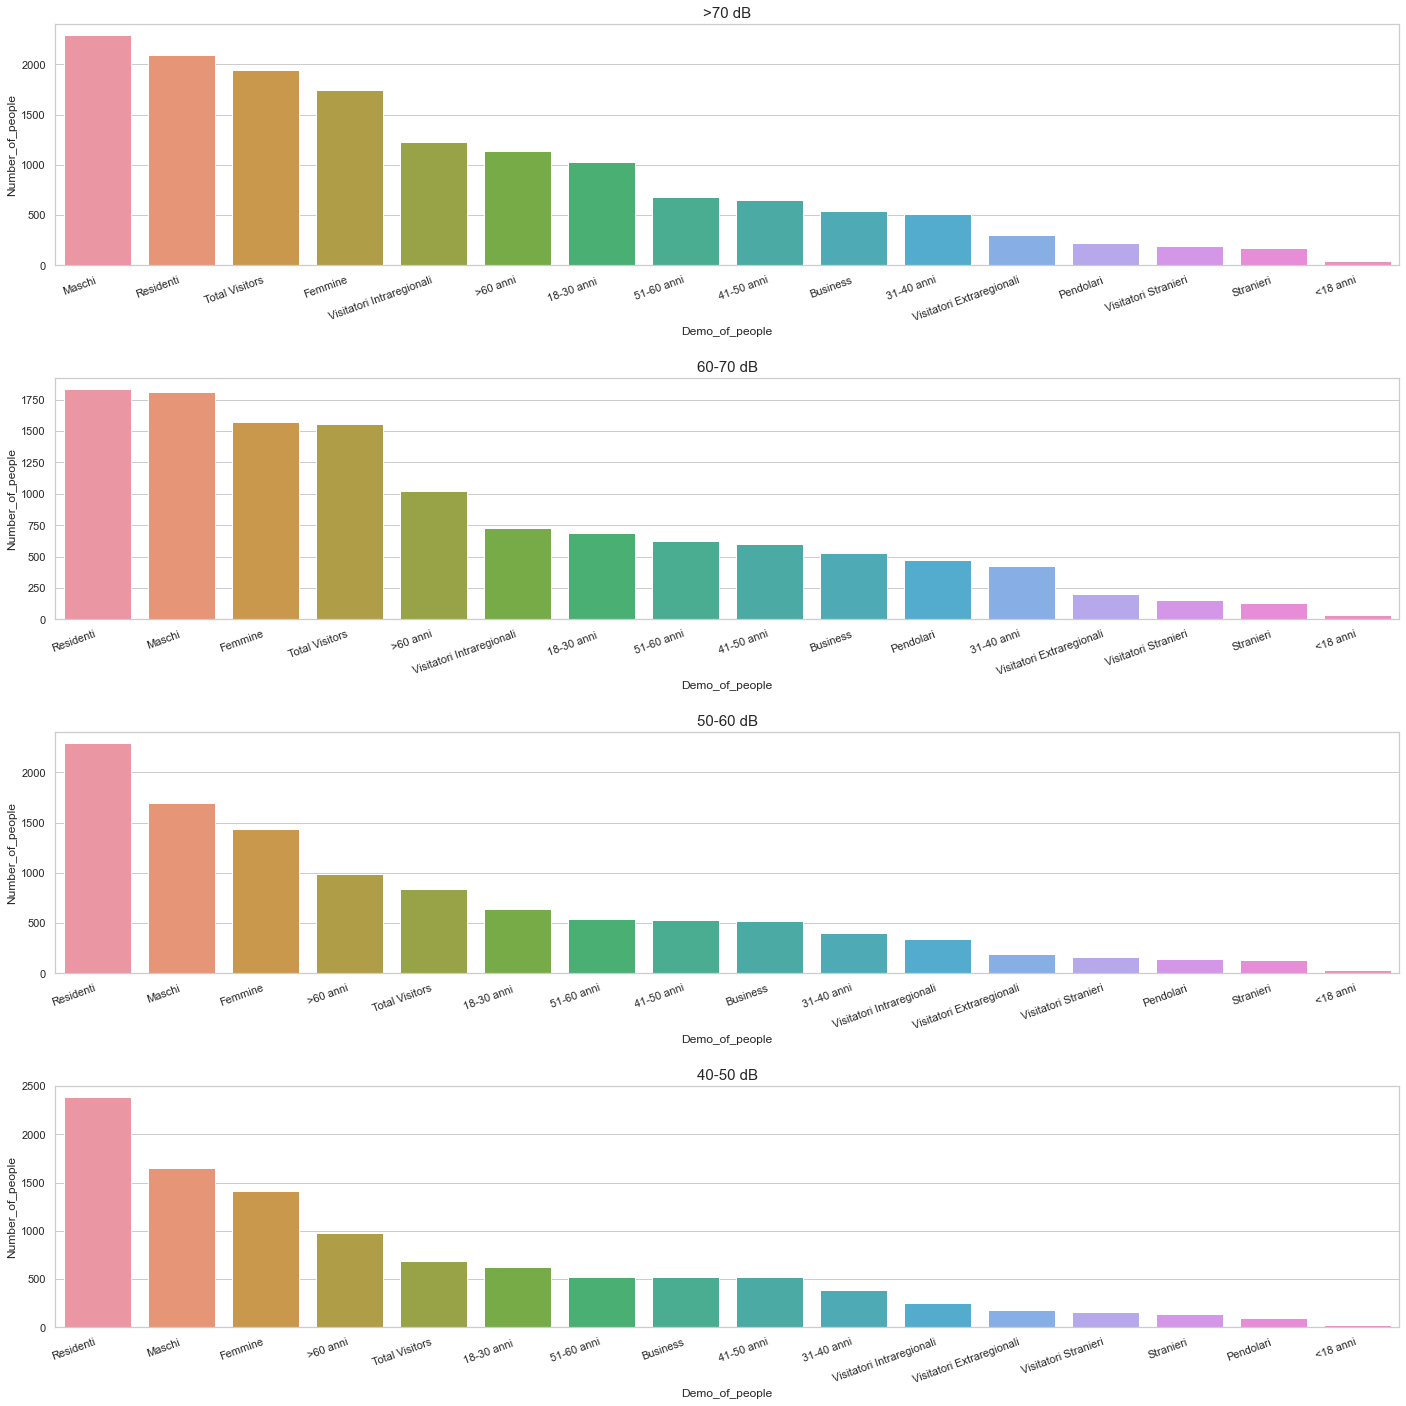

In [24]:
fig, ax = plt.subplots(4,1,figsize=(20,20))
axes = ax.ravel()

# >70 dB
ND_70 = noise_groups (N_D, 70, 80) 
sns.barplot(x='Demo_of_people', y='Number_of_people', data=ND_70, ax=axes[0])
ax[0].set_title('>70 dB', fontsize=15)
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=20, ha='right')

# 60-70 dB
ND_60 = noise_groups (N_D, 60, 70)
sns.barplot(x='Demo_of_people', y='Number_of_people', data=ND_60, ax=axes[1])
ax[1].set_title('60-70 dB', fontsize=15)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=20, ha='right')

# 50-60 dB
#axes[2].get_xticklabels()
ND_50 = noise_groups (N_D, 50, 60)
sns.barplot(x='Demo_of_people', y='Number_of_people', data=ND_50, ax=axes[2])
ax[2].set_title('50-60 dB', fontsize=15)
axes[2].set_xticklabels(axes[2].get_xticklabels(),rotation=20, ha='right')

# 40-50 dB
ND_40 = noise_groups (N_D, 40, 50)
sns.barplot(x='Demo_of_people', y='Number_of_people', data=ND_40, ax=axes[3])
ax[3].set_title('40-50 dB', fontsize=15)
axes[3].set_xticklabels(axes[3].get_xticklabels(),rotation=20, ha='right')

fig.tight_layout(pad=2.0)

    Figure 14 - Number of people per day and hour for each demographic characteristic, and divided into 4 ranges of dB (40-50 dB, 50-60 dB, 60-70 dB and >70 dB)

Gender, age and visitors analysis:
    
- when there are maximum dB levels there is an increase in the number of males compared to females and even is noticed that the maximum changes to males instead of being the residents;
    
- regarding the ages: with the increase in dB there is an increase in the population of 18-30 so that for 40-50 dB, the difference between >60 and 18-30 is 500 dB and for >70 it is 200 dB. These two age groups are followed by 51-60, 41-50, and then 31-40 years old;
    
- about the type of visitors: residents are always the group of visitors with the highest number of people for each dB level. It turns out that intraregional visitors are always in second, however, there is a clear increase in the number of people to the highest noise levels. For example, in 40-50 dB the difference between residents and intraregional visitors is 2000 people and for >70 dB it is only 1000 people.
    

Conclusions:
- maximum dB levels are related to an increase in the male gender, to an increase of 18-30 years old people and to an increase of intraregional visitors. The following three figures are for each one of these demographic characteristics and where is visible the increase of noise with the increase of number of people.

<AxesSubplot:xlabel='Number_of_people', ylabel='C_avg'>

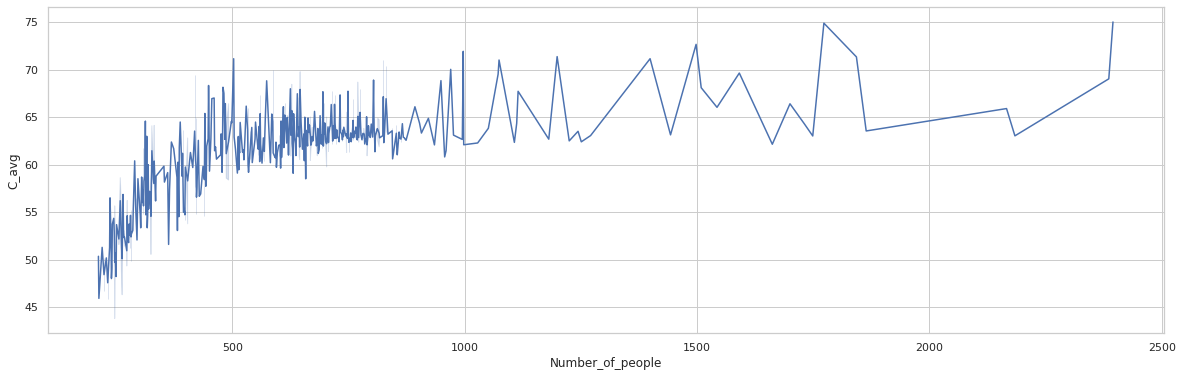

In [41]:
# Visitatori Intraregionali
N_D_visi = N_D[N_D['Demo_of_people']=='Visitatori Intraregionali']
fig, ax = plt.subplots(figsize=(20,6))
sns.lineplot(data=N_D_visi, x="Number_of_people", y="C_avg", ax=ax)

                  Figure 15 - Number of Visitatori Intraregionali versus noise level average

<AxesSubplot:xlabel='Number_of_people', ylabel='C_avg'>

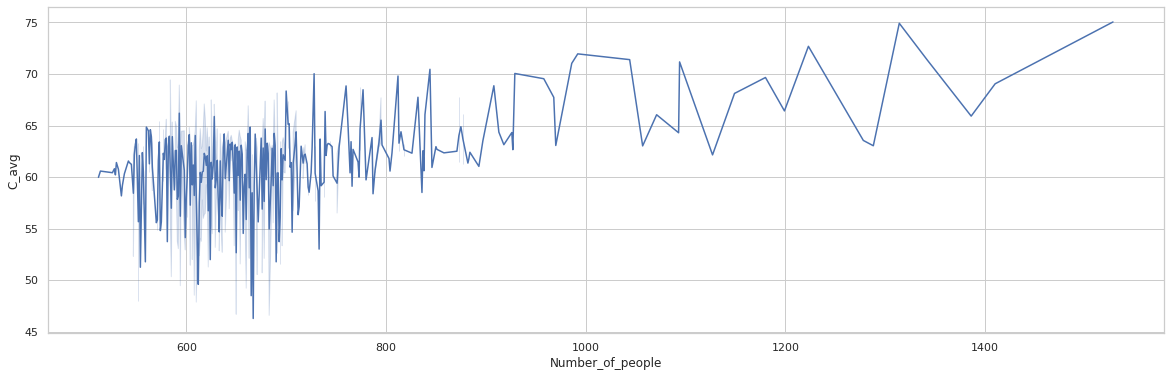

In [42]:
# 18-30 anni
N_D_18 = N_D[N_D['Demo_of_people']=='18-30 anni ']
fig, ax = plt.subplots(figsize=(20,6))
sns.lineplot(data=N_D_18, x="Number_of_people", y="C_avg", ax=ax)

               Figure 16 - Number of people with ages between 18 and 30 versus noise level average

<AxesSubplot:xlabel='Number_of_people', ylabel='C_avg'>

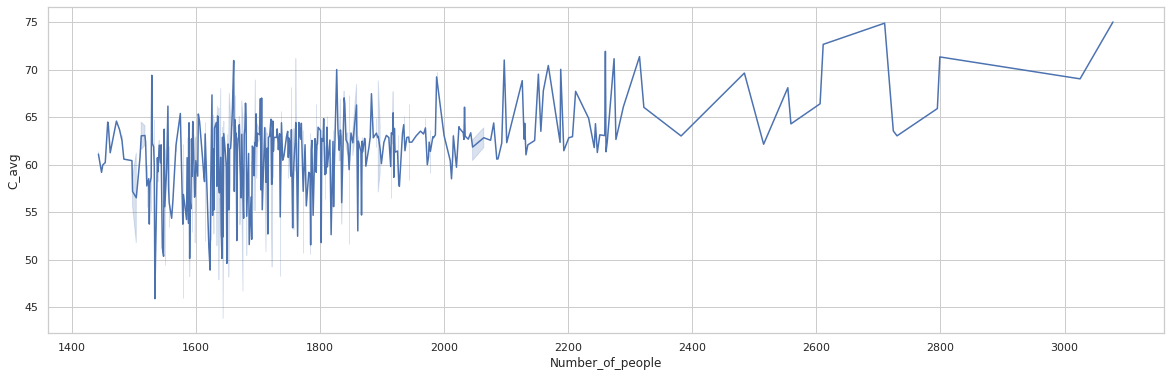

In [43]:
# Maschi
N_D_M = N_D[N_D['Demo_of_people']=='Maschi']
fig, ax = plt.subplots(figsize=(20,6))
sns.lineplot(data=N_D_M, x="Number_of_people", y="C_avg", ax=ax)

                  Figure 17 - Number of men versus noise level average

### Analysis of Complaints to the police of excessive noise

We go into a more through analysis of the complaints dataset, but now we analyse all districts of Torino.

In [44]:
df_complaints = read_complaints()
df_complaints.head()

,Categoria criminologa,Sottocategoria Criminologica,Circoscrizione,Localita,Area Verde,Data,Ora
560,Convivenza Civile,Rumori molesti,1.0,MISERICORDIA/(VIA),NaN,2016-01-03,NaT
560,Convivenza Civile,Rumori molesti,1.0,MISERICORDIA/(VIA),NaN,2016-01-03,NaT
540,Convivenza Civile,Rumori molesti,9.0,NIZZA/(VIA),NaN,2016-01-15,NaT
540,Convivenza Civile,Rumori molesti,9.0,NIZZA/(VIA),NaN,2016-01-15,NaT
541,Convivenza Civile,Rumori molesti,7.0,CIGNA/FRANCESCO (LARGO),NaN,2016-01-16,NaT


In [45]:
#Aggregate complaints per day
df_complaints_day=df_complaints.groupby(pd.Grouper(key="Data", freq="D", origin='2016-01-01')).size().reset_index(name='counts').sort_values("Data")
df_complaints_day_district8=df_complaints.loc[df_complaints['Circoscrizione'] == 8.0].groupby(pd.Grouper(key="Data", freq="D", origin='2016-01-01')).size().reset_index(name='counts').sort_values("Data")
df_complaints_day.head()

,Data,counts
0,2016-01-03,2
1,2016-01-04,0
2,2016-01-05,0
3,2016-01-06,0
4,2016-01-07,0


In [46]:
#Aggregate complaints per hour (most entries don't have hour)
df_complaints_hour=df_complaints.groupby(pd.Grouper(key="Ora", freq="H")).size().reset_index(name='counts').sort_values("Ora")
df_complaints_hour.head(12)

,Ora,counts
0,1900-01-01 07:00:00,5
1,1900-01-01 08:00:00,7
2,1900-01-01 09:00:00,15
3,1900-01-01 10:00:00,19
4,1900-01-01 11:00:00,19
5,1900-01-01 12:00:00,14
6,1900-01-01 13:00:00,8
7,1900-01-01 14:00:00,7
8,1900-01-01 15:00:00,2


We have observed that complains occur mostly during the morning. In fact, there are no complaints of excessive noise registered at nigh time, only between 07h and 15h. This contradicts logic, as one would assume that excessive noise would be more annoying to people during night periods, which would lead to more complaints at night time. However, a possible explanation to this is that either complaints are registered only during the next day and not immediatelly after a complaint is received by the police or it is not possible to register noise compltaints at night at all, so people present their complaints during the next day.  

### Weather from IoT sensors

In [47]:
def obj_col_to_float(df, col):
    df[col] = df[col].astype(str).str.replace(',', '.')
    df[col]=df[col].astype(float)
    
    return df

In [48]:
# C1 = TORINO GIARDINI REALI, Rain level about 10 minutes - Millimeters;;;
df_rain = pd.read_csv('./Data/weather/weather_rain.csv', sep=';')[['Date', 'Hour', 'C1']].rename(columns={'C1':'rain_mm'})
# C1 = TORINO GIARDINI REALI, Wind speed (scalar) - Meters per second;;
df_wind_speed = pd.read_csv('./Data/weather/weather_wind_speed.csv', sep=';')[['Date', 'Hour', 'C1']].rename(columns={'C1':'wind_speed_ms'})
# C1 = TORINO GIARDINI REALI, Wind speed (gust) - Meters per second;;
df_wind_gust = pd.read_csv('./Data/weather/weather_wind_gust.csv', sep=';')[['Date', 'Hour', 'C1']].rename(columns={'C1':'wind_gust_ms'})
# C1 = TORINO GIARDINI REALI, Snow depth - Meters;;;
# C2 = TORINO GIARDINI REALI, Air temperature - Degrees Celsius;;;
df_snow_temperature = pd.read_csv('./Data/weather/weather_snow_temperature.csv', sep=';')[['Date', 'Hour', 'C1', 'C2']].rename(columns={'C1':'snow_m', 'C2': 'temperature_c'})


df_weather=pd.merge(df_rain, df_wind_speed, left_on=["Date", "Hour"], right_on=["Date", "Hour"], how='outer')
df_weather=pd.merge(df_weather, df_wind_gust, left_on=["Date", "Hour"], right_on=["Date", "Hour"], how='outer')
df_weather=pd.merge(df_weather, df_snow_temperature, left_on=["Date", "Hour"], right_on=["Date", "Hour"], how='outer')

df_weather["Date"]=pd.to_datetime(df_weather['Date'], utc=True).astype('datetime64[ns]')
df_weather=obj_col_to_float(df_weather, "rain_mm")
df_weather=obj_col_to_float(df_weather, "wind_speed_ms")
df_weather=obj_col_to_float(df_weather, "wind_gust_ms")
df_weather=obj_col_to_float(df_weather, "snow_m")
df_weather=obj_col_to_float(df_weather, "temperature_c")

df_weather.head()

,Date,Hour,rain_mm,wind_speed_ms,wind_gust_ms,snow_m,temperature_c
0,2016-01-06,00:00,NaN,NaN,NaN,NaN,NaN
1,2016-01-06,00:10,0.0,0.6,NaN,NaN,NaN
2,2016-01-06,00:20,0.0,0.7,NaN,NaN,NaN
3,2016-01-06,00:30,0.0,0.8,NaN,-0.02,14.2
4,2016-01-06,00:40,0.0,0.8,NaN,NaN,NaN


In [49]:
#Generate aggregated values per day
df_weather_day=df_weather.groupby("Date", dropna=True).agg({
    'rain_mm': 'mean', 
    'wind_speed_ms': 'mean',
    'wind_gust_ms': 'mean',
    'snow_m': 'mean',
    'temperature_c': 'mean'
}) 

df_weather_day.head()

,rain_mm,wind_speed_ms,wind_gust_ms,snow_m,temperature_c
Date,,,,,
2016-01-06,0.000000,0.731469,2.126087,0.017872,17.736170
2016-01-07,0.000000,0.260839,1.404348,0.031489,24.648936
2016-01-08,0.001399,0.470629,2.226087,-0.005106,24.785106
2016-01-09,0.000000,0.481119,1.565217,-0.006809,24.536170
2016-01-10,0.000000,0.467133,1.652174,0.025532,16.946809


In [50]:
#Generate aggregated values per hour
df_weather_hour=df_weather

df_weather_hour["Hour"]=pd.to_datetime(df_weather['Hour'].astype(str), utc=True, format='%H:%M').values.astype('<M8[h]')

df_weather_hour=df_weather.groupby("Hour", dropna=True).agg({
    'rain_mm': 'mean', 
    'wind_speed_ms': 'mean',
    'wind_gust_ms': 'mean',
    'snow_m': 'mean',
    'temperature_c': 'mean'
}) 

df_weather_hour=df_weather_hour.reset_index()

df_weather_hour.head()

,Hour,rain_mm,wind_speed_ms,wind_gust_ms,snow_m,temperature_c
0,1900-01-01 00:00:00,0.015665,0.287866,NaN,0.045073,11.895652
1,1900-01-01 01:00:00,0.012034,0.283394,1.226715,0.043985,11.592841
2,1900-01-01 02:00:00,0.014851,0.266577,1.238378,0.046364,11.239292
3,1900-01-01 03:00:00,0.012147,0.267327,1.200901,0.048031,10.902588
4,1900-01-01 04:00:00,0.013539,0.263483,1.233514,0.049485,10.610879


### Holidays

In [51]:
df_holidays=None 

for year in range (2016, 2022): 
    with open('./Data/holidays/{}.json'.format(year)) as f:
        data = json.load(f)

    curr = pd.json_normalize(data, ["response", 'holidays'])
    if df_holidays is None:
        df_holidays = curr
    else:
        df_holidays=pd.concat([df_holidays, curr])

df_holidays['date.iso'] = pd.to_datetime(df_holidays['date.iso'], utc=True).astype('datetime64[ns]')
print(df_holidays.shape)

df_holidays=df_holidays[["name", "description", "type", "date.iso", "locations", "states"]]
df_holidays.head()

(144, 19)


,name,description,type,date.iso,locations,states
0,New Year's Day,New Year’s Day is celebrated in Italy on Janua...,[National holiday],2016-01-01 00:00:00,All,All
1,Epiphany,Epiphany is a national holiday in Italy celebr...,[National holiday],2016-01-06 00:00:00,All,All
2,March Equinox,March Equinox in Italy (Rome),[Season],2016-03-20 04:30:04,All,All
3,Good Friday,Good Friday is part of the Holy Week of Easter...,[Observance],2016-03-25 00:00:00,All,All
4,Easter Sunday,Easter Day is a public holiday that is celebra...,[Observance],2016-03-27 00:00:00,All,All


### Football games

In [52]:
df_football=None 

for year in range (2015, 2021): 
    curr = pd.read_csv('./Data/football/series_a/{}.csv'.format(year), sep=',')[['Date', 'HomeTeam', 'AwayTeam']]
    if df_football is None:
        df_football = curr
    else:
        df_football=pd.concat([df_football, curr])

df_football["Date"]=pd.to_datetime(df_football['Date'], utc=True).astype('datetime64[ns]')

# Filter by games related at fc torino
df_football=df_football[df_football['HomeTeam']=='Torino']
df_football.head()

,Date,HomeTeam,AwayTeam
18,2015-08-30,Torino,Fiorentina
39,2015-09-20,Torino,Sampdoria
56,2015-09-27,Torino,Palermo
71,2015-10-17,Torino,Milan
97,2015-10-28,Torino,Genoa


### Correlation Analysis between Noise Peaks and Complaints

In [53]:
#Aggregate noise peaks per day
df_out_max_per_day=df_out.groupby(pd.Grouper(key="date", freq = 'D')).agg({'C1': 'max'})

df_outlier_day = (df_out.set_index('date')
               .groupby([pd.Grouper(freq = 'D'),'is_outlier'])
               .size()
               .unstack(fill_value=0))

df_max_peaks_day=pd.merge(df_out_max_per_day, df_outlier_day, left_on="date", right_on="date")[[1, "C1"]].rename(columns={1: "noise_peaks", 'C1':'max_day_peak'})

df_max_peaks_day.head()

,noise_peaks,max_day_peak
date,,
2016-06-01,3,69.1
2016-06-02,3,70.8
2016-06-03,4,68.4
2016-06-04,8,71.4
2016-06-05,5,69.9


<AxesSubplot:xlabel='date'>

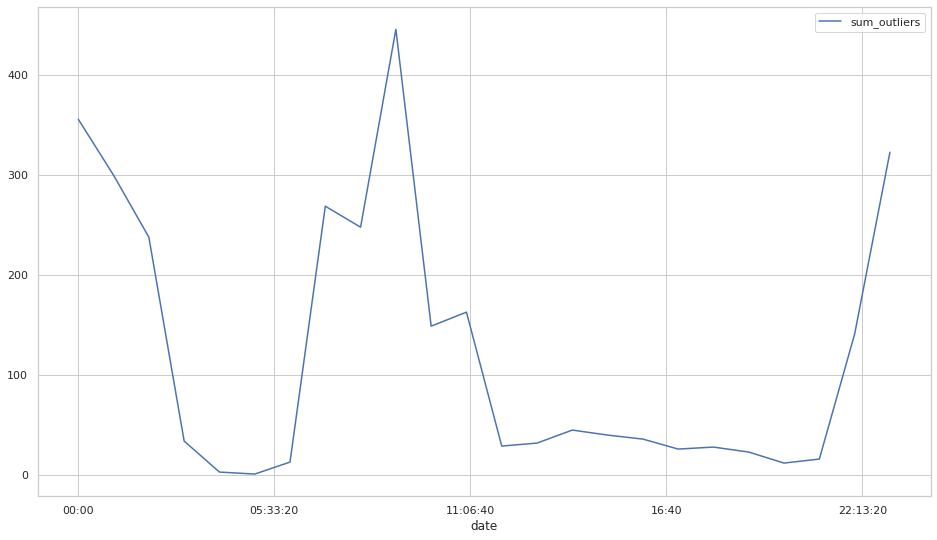

In [54]:
#Aggregate noise peaks per hour
df_outlier_hour = df_out.groupby(df_out.date.dt.time).agg({"is_outlier": "sum"}).rename(columns={"is_outlier": "sum_outliers"})
df_outlier_hour
#df_max_peaks_hour=pd.merge(df_out_max_per_hour, df_outlier_hour, left_on="date", right_on="date")[[True, "C1"]].rename(columns={True: "noise_peaks", 'C1':'max_day_peak'})

df_outlier_hour.plot(figsize=(16,8))

                 Figure 18 - Evolution of the number of noise peaks over the hours

In this figure, the sum of outliers, that is, the sum of the noise peaks is represented over the hours of the day. The first peak in the number of outliers is found for the hours in the morning between 7 am and 10 am, which corresponds to the hours when people leave for work and school, and the second peak for the night and dawn, between 11 pm and 3 am in the morning.

Thus, the two periods of the day that stand out, can be related to activities with greater concentration of the number of people, in the morning with people going to work, among others, and at night related to nightlife.

<AxesSubplot:xlabel='Data'>

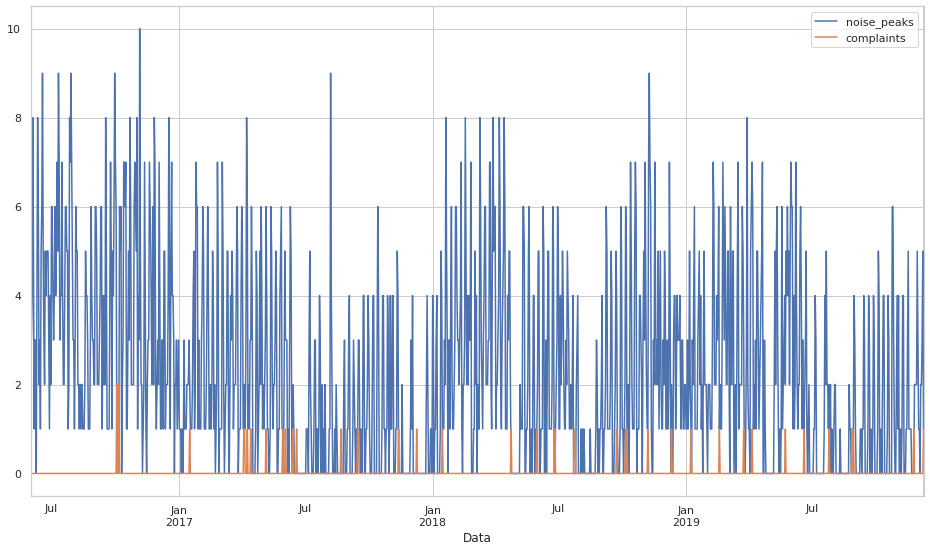

In [55]:
# Merge complaints and noise peaks for district 8 (san salvario)
df_merged=pd.merge(df_complaints_day, df_max_peaks_day, left_on=["Data"], right_on=["date"], how='inner')

df_comp_peaks_day=df_merged[['Data', 'counts', "noise_peaks", "max_day_peak"]].rename(columns={'counts':'complaints'})

df_merged=pd.merge(df_complaints_day_district8, df_max_peaks_day, left_on=["Data"], right_on=["date"], how='inner')
df_comp_peaks_day_district8=df_merged[['Data', 'counts', "noise_peaks", "max_day_peak"]].rename(columns={'counts':'complaints'})

df_comp_peaks_day_district8.plot(x="Data", y=["noise_peaks", "complaints"], figsize=(16,9))

                 Figure 19 - Evolution of the number of noise peaks versus complains

When comparing the number of noise peaks with the number of complaints, neither relationships nor patterns are verified.

#### Noise complaints per day vs noise peaks (anomalies)

<AxesSubplot:>

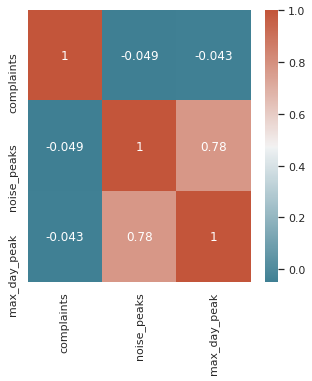

In [56]:
# calculate correlation matrix
corr = df_comp_peaks_day_district8.corr() # plot the heatmap
fig,ax = plt.subplots(figsize=(5,5))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True,
            cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax )

             Figure 20 - Correlation matrix between complains, noise peaks and maximum peak

Regarding the correlation, it appears that the maximum peak of the day is highly correlated with the noise peaks. Complaints are not correlated with any of the other variables.

In [57]:
df_peaks_comps=df_comp_peaks_day_district8.groupby("noise_peaks").agg({'complaints': 'sum'}) 

<AxesSubplot:title={'center':'Noise peaks vs complaints per day'}, xlabel='Number of noise peaks', ylabel='Number of complaints'>

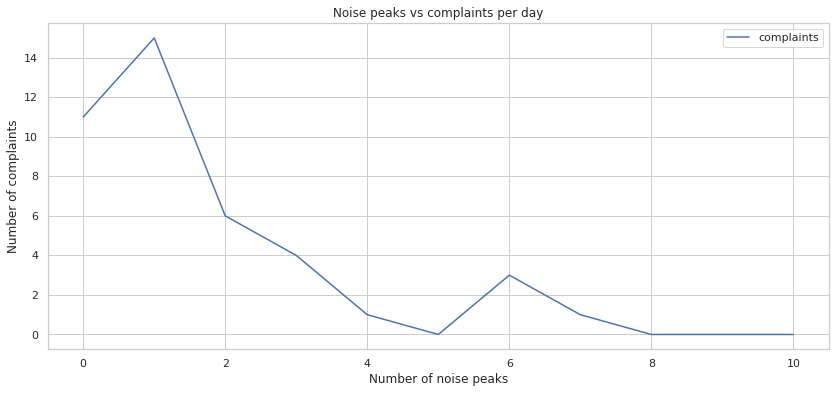

In [58]:
df_peaks_comps.plot(figsize=(14,6), ylabel="Number of complaints", xlabel="Number of noise peaks", 
                    title="Noise peaks vs complaints per day")

                 Figure 21 - Noise peaks versus the number of complains

Contrary to expectations, the number of complaints is maximum for low noise peaks.

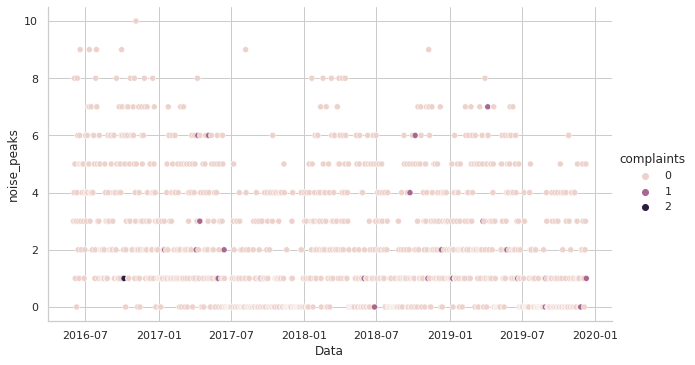

In [59]:
sns.relplot(x="Data", y="noise_peaks", hue="complaints", data=df_comp_peaks_day_district8,  height=5, aspect=1.7)

             Figure 22 - Evolution of the number of noise peaks versus complains

Again, there are no patterns between noise peaks and the number of complaints.

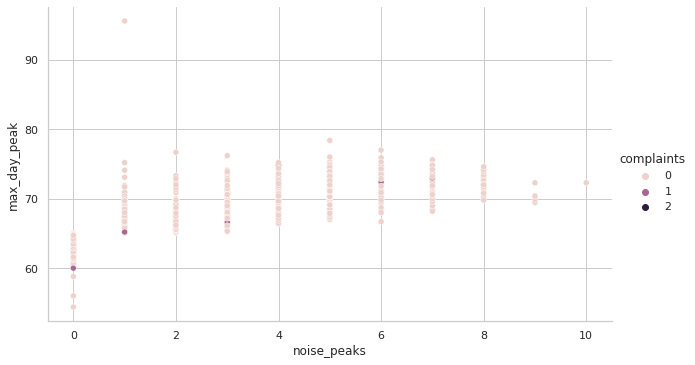

In [60]:
sns.relplot(x="noise_peaks", y="max_day_peak",  hue="complaints", data=df_comp_peaks_day_district8,  height=5, aspect=1.7)

             Figure 23 - Number of noise peaks versus the maximum peak versus complains

When we don't have any peaks, the maximum day peak is logically small. When we have peaks then we have a maximum day noise peak that is larger.  


However, having larger day noise peaks doesn't necessaraly mean more complaints, neither does having more noise peaks in a day.

#### Weather

In [61]:
# Merge dfs
df_merged=pd.merge(df_comp_peaks_day, df_weather_day, left_on=["Data"], right_on=["Date"], how='outer')
df_merged=df_merged[df_merged["Data"].notnull()]

df_merged

,Data,complaints,noise_peaks,max_day_peak,rain_mm,wind_speed_ms,wind_gust_ms,snow_m,temperature_c
0,2016-06-01,0.0,3.0,69.1,NaN,NaN,NaN,NaN,NaN
1,2016-06-02,0.0,3.0,70.8,NaN,NaN,NaN,NaN,NaN
2,2016-06-03,0.0,4.0,68.4,NaN,NaN,NaN,NaN,NaN
3,2016-06-04,4.0,8.0,71.4,NaN,NaN,NaN,NaN,NaN
4,2016-06-05,0.0,5.0,69.9,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1286,2019-12-09,1.0,1.0,65.2,0.000000,NaN,NaN,0.087021,20.344681
1287,2019-12-10,0.0,0.0,64.7,0.000000,NaN,NaN,0.022222,13.648936
1288,2019-12-11,0.0,1.0,70.7,0.001399,NaN,NaN,0.010000,7.517021
1289,2019-12-12,0.0,2.0,66.0,0.000000,NaN,NaN,-0.007447,2.393617


**Overall correlation**

<AxesSubplot:>

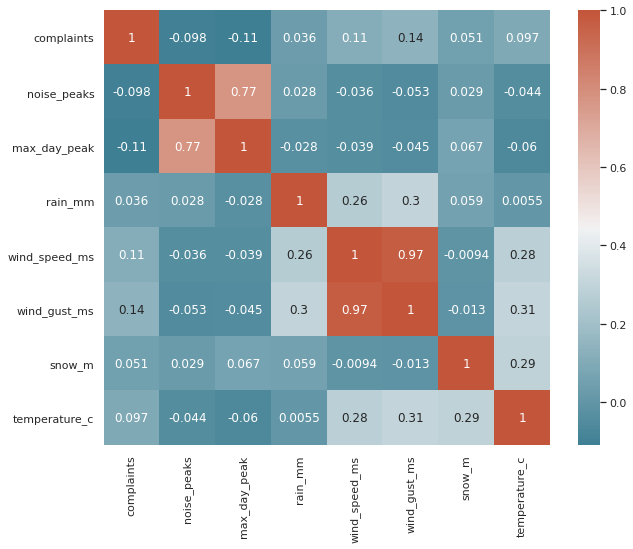

In [62]:
# calculate correlation matrix
corr = df_merged.corr()# plot the heatmap
plt.figure(figsize = (10,8))

sns.heatmap(
    corr, 
    xticklabels=corr.columns, 
    yticklabels=corr.columns, 
    annot=True, 
    cmap=sns.diverging_palette(220, 20, as_cmap=True)
)

             Figure 24 - Correlation matrix between weather data

From the correlation of weather variables with complaints and noise levels, there are no evident correlations. Again, the correlation between noise_peaks and max_day_peak is verified, and correlations between weather variables such as wind_gust and wind_speed is highlighted.

##### Wind vs Noise Complaints vs Noise Peaks

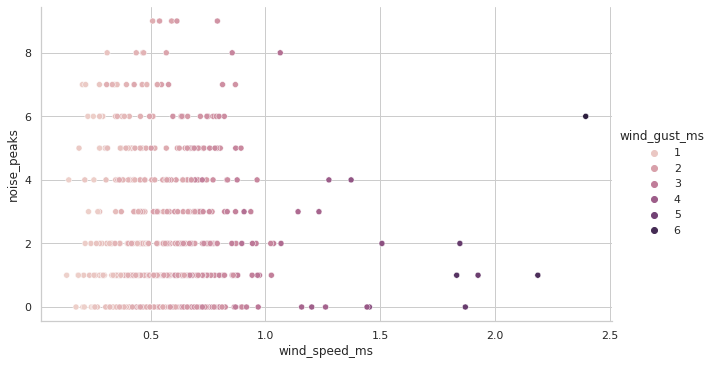

In [63]:
sns.relplot(x="wind_speed_ms", y="noise_peaks", hue="wind_gust_ms", data=df_merged, height=5, aspect=1.7);

             Figure 25 - Number of noise peaks versus the wind speed and acceleration

This figure highlights the fact that with the increase in wind speed there is a decrease in noise peaks. This can be explained by the lowest number of people going out due to the weather and, therefore, the street movement decreases and, consequently, there is less noise.

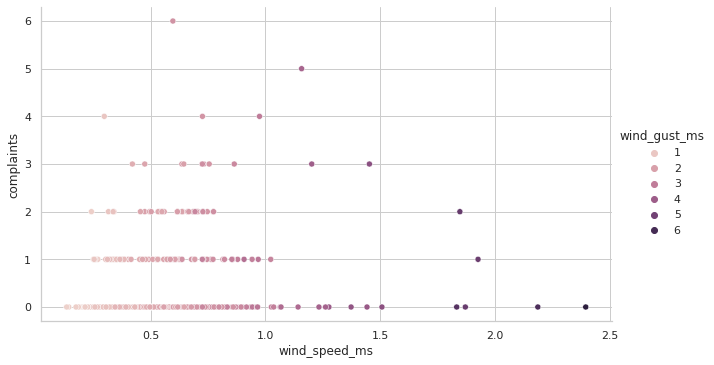

In [64]:
sns.relplot(x="wind_speed_ms", y="complaints", hue="wind_gust_ms", data=df_merged, height=5, aspect=1.7);

             Figure 26 - Number of complaints versus the maximum peak versus complains

Regarding complaints, wind speed does not seem to increase the number of complaints and there are no obvious patterns between these two variables.

##### Temperature/Snow vs Noise Complaints vs Noise Peaks

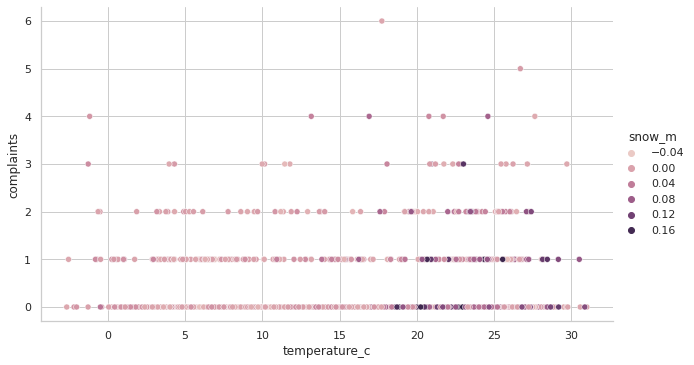

In [65]:
sns.relplot(x="temperature_c", y="complaints", hue="snow_m", data=df_merged, height=5, aspect=1.7);

             Figure 27 - Number of complaints versus the temperature versus snow meters

Between temperature and complaints there is no evidence of relationships.

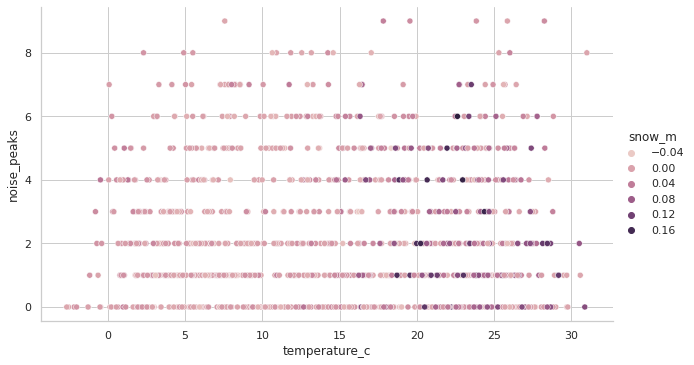

In [66]:
sns.relplot(x="temperature_c", y="noise_peaks", hue="snow_m", data=df_merged, height=5, aspect=1.7);

             Figure 28 - Number of noise peaks versus the temperature versus the snow meters

Between noise peaks and temperature, no relevant patterns are detected, with a wide dispersion of values.

##### Rain vs Noise Complaints vs Noise Peaks

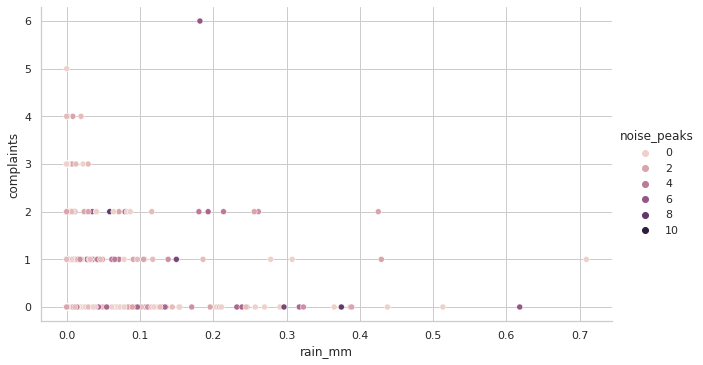

In [67]:
sns.relplot(x="rain_mm", y="complaints", hue="noise_peaks", data=df_merged, height=5, aspect=1.7);

             Figure 29 - Number of complaints versus the rain mm versus noise peaks

Between complaints and rain, there seems to be a relationship because the less the rain, the greater the number of complaints, which makes sense because when there is a lot of rain people do not go out and the streets are less crowded. Yet this relationship is not very evident.

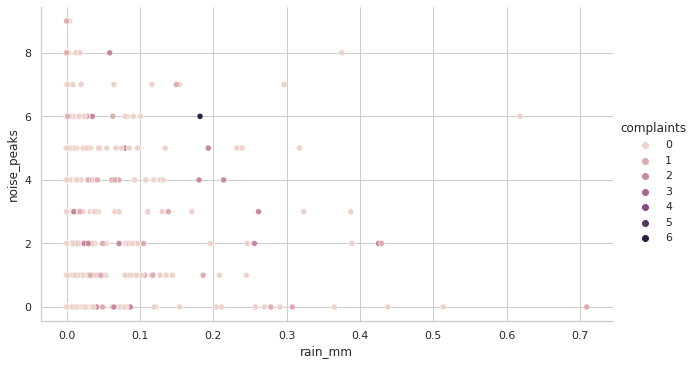

In [68]:
sns.relplot(x="rain_mm", y="noise_peaks", hue="complaints", data=df_merged, height=5, aspect=1.7);

             Figure 30 - Number of noise peaks versus the rain mm versus complains

We can verify that whenever we have more rain then we have fewer noise peaks. Therefore, this can lead to the conclusion that when there is more rain then we will have fewer people around each other on the roads/restaurants/etc. and ultimately less noise.

##### Rain vs wind speed vs noise peaks

<AxesSubplot:>

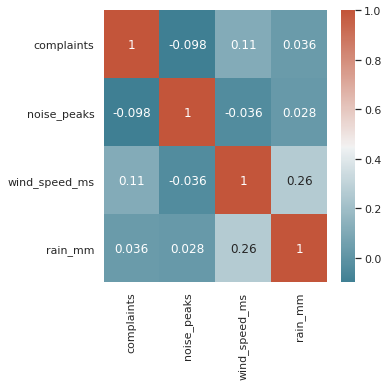

In [69]:
# calculate correlation matrix
corr = df_merged[["complaints", "noise_peaks", "wind_speed_ms", "rain_mm"]].corr()# plot the heatmap
plt.figure(figsize = (5,5))

sns.heatmap(
    corr, 
    xticklabels=corr.columns, 
    yticklabels=corr.columns, 
    annot=True, 
    cmap=sns.diverging_palette(220, 20, as_cmap=True)
)

            Figure 31 - Correlation matrix between rain, wind, noise peaks and complaints

Among complaints, noise peaks, wind speed and rain, there are no correlations between variables.

#### Analysis per hour

In [70]:
# Merge dfs
df_merged=pd.merge(df_weather_hour, df_complaints_hour, left_on=["Hour"], right_on=["Ora"], how='outer')
df_merged["Hour"]=df_merged.Hour.dt.time
df_merged=pd.merge(df_merged, df_outlier_hour, left_on=["Hour"], right_on=["date"], how='outer')

#df_merged=df_merged[df_merged["counts"].notnull()]

df_peaks_comps_hour=df_merged
del df_peaks_comps_hour["Ora"]

df_peaks_comps_hour.head()

,Hour,rain_mm,wind_speed_ms,wind_gust_ms,snow_m,temperature_c,counts,sum_outliers
0,00:00:00,0.015665,0.287866,NaN,0.045073,11.895652,NaN,356
1,01:00:00,0.012034,0.283394,1.226715,0.043985,11.592841,NaN,300
2,02:00:00,0.014851,0.266577,1.238378,0.046364,11.239292,NaN,238
3,03:00:00,0.012147,0.267327,1.200901,0.048031,10.902588,NaN,34
4,04:00:00,0.013539,0.263483,1.233514,0.049485,10.610879,NaN,3


<AxesSubplot:>

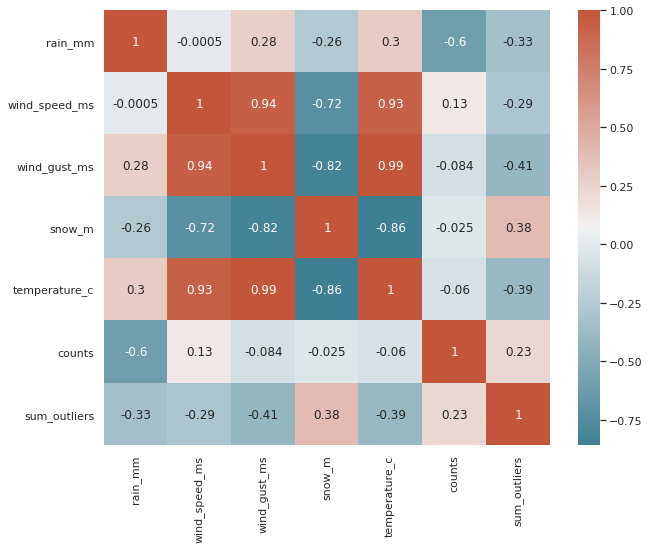

In [71]:
# calculate correlation matrix
corr = df_peaks_comps_hour.corr()# plot the heatmap
plt.figure(figsize = (10,8))

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, 
            cmap=sns.diverging_palette(220, 20, as_cmap=True))

                                 Figure 32 - Correlation matrix

Of the above-mentioned correlations, only positive correlations between weather variables stand out. The maximum positive correlation is for wind gust and temperature, the second for wind gust and wind speed and the third for wind speed and temperature. In the negative correlation, the snow and temperature pair stand out.

#### Weekends vs noise peaks

In [72]:
# Assign bool var
df_comp_peaks_day['IsWeekend'] = df_comp_peaks_day.apply(lambda row: True if row.Data.weekday() > 4 else False, axis=1)

# project values
df_weekend=df_comp_peaks_day[["Data", "complaints", "noise_peaks", "IsWeekend"]]
df_weekend.head()

,Data,complaints,noise_peaks,IsWeekend
0,2016-06-01,0,3,False
1,2016-06-02,0,3,False
2,2016-06-03,0,4,False
3,2016-06-04,4,8,True
4,2016-06-05,0,5,True


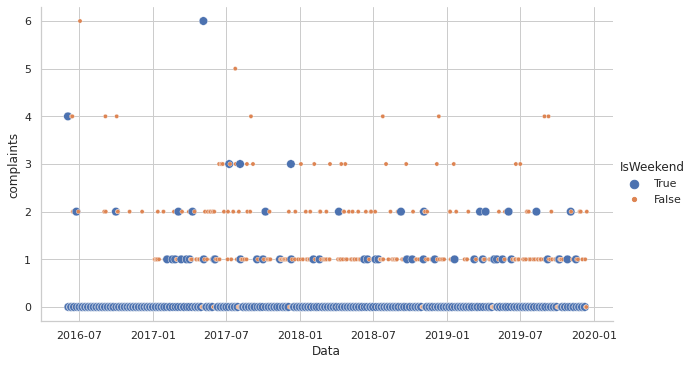

In [73]:
sns.relplot(x="Data", y="complaints", hue="IsWeekend", hue_order=[True, False], 
            size_order=[True, False], size="IsWeekend", data=df_weekend, height=5, aspect=1.7)

                 Figure 33 - Number of complaints over time versus weekend days

From the figure above, it can be seen that the distribution of the number of complaints over the days of the week is similar and there is no obvious relationship.

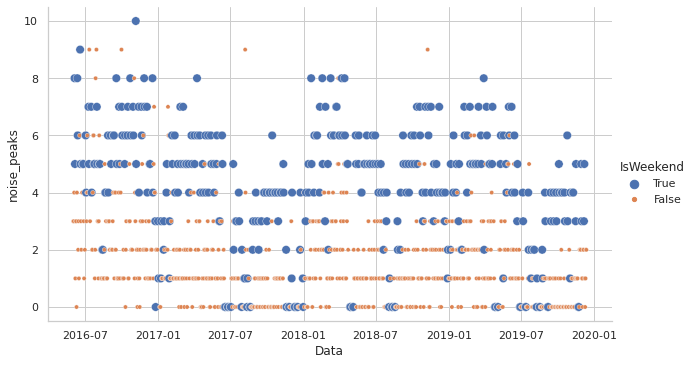

In [74]:
sns.relplot(x="Data", y="noise_peaks", hue="IsWeekend", hue_order=[True, False], size_order=[True, False], size="IsWeekend", 
            data=df_weekend, height=5, aspect=1.7)

                 Figure 34 - Number of noise peaks over time versus weekend days

Regarding noise peaks and weekends, it appears that the highest number of noise peaks is related to weekends. This can be explained by the fact that people go out more during the weekend, so the streets are more crowded and there is more noise.

#### Holidays vs noise peaks

In [75]:
# Merge dfs
df_merged=pd.merge(df_comp_peaks_day, df_holidays, left_on=["Data"], right_on=["date.iso"], how='outer')
df_merged=df_merged[df_merged["Data"].notnull()]

# Assign bool var
df_merged['IsHoliday'] = df_merged.apply(lambda row: False if pd.isnull(row['type'])  else True, axis=1)

# project values
df_metrics_holidays_day=df_merged[["Data", "complaints", "noise_peaks", "IsHoliday"]]
df_metrics_holidays_day.head()

,Data,complaints,noise_peaks,IsHoliday
0,2016-06-01,0.0,3.0,False
1,2016-06-02,0.0,3.0,True
2,2016-06-03,0.0,4.0,False
3,2016-06-04,4.0,8.0,False
4,2016-06-05,0.0,5.0,False


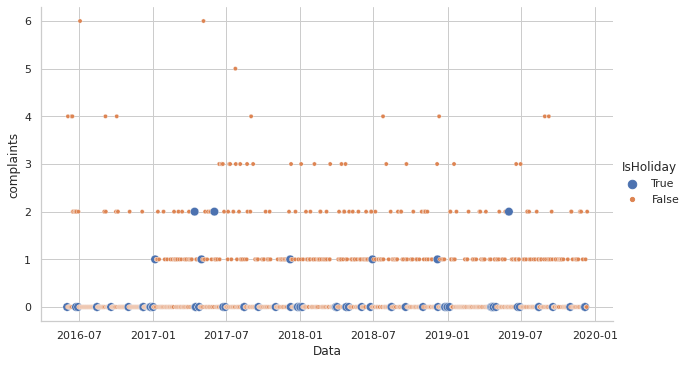

In [76]:
sns.relplot(x="Data", y="complaints", hue="IsHoliday", hue_order=[True, False], size_order=[True, False], size="IsHoliday", 
            data=df_metrics_holidays_day, height=5, aspect=1.7);

                 Figure 35 - Number of complaints over time versus holidays days

As for complaints, it appears that the greatest number of complaints are not on holidays.

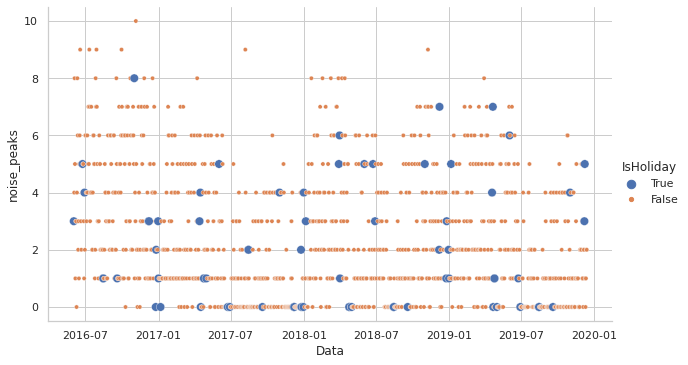

In [77]:
sns.relplot(x="Data", y="noise_peaks", hue="IsHoliday", hue_order=[True, False], size_order=[True, False], size="IsHoliday", 
            data=df_metrics_holidays_day, height=5, aspect=1.7);

                 Figure 36 - Number of noise peaks over time versus holidays days

From the figure above it can be seen that on most holidays there are noise peaks, showing relationships between holidays and noise peaks.

#### Football vs noise peaks

In [78]:
# Merge dfs
df_merged=pd.merge(df_comp_peaks_day, df_football, left_on=["Data"], right_on=["Date"], how='outer')
df_merged=df_merged[df_merged["Data"].notnull()]

# Assign bool var
df_merged['IsFootball'] = df_merged.apply(lambda row: False if pd.isnull(row['HomeTeam'])  else True, axis=1)

# project values
df_metrics_football_day=df_merged[["Data", "complaints", "noise_peaks", "IsFootball"]]
df_metrics_football_day.head()

,Data,complaints,noise_peaks,IsFootball
0,2016-06-01,0.0,3.0,False
1,2016-06-02,0.0,3.0,False
2,2016-06-03,0.0,4.0,True
3,2016-06-04,4.0,8.0,False
4,2016-06-05,0.0,5.0,False


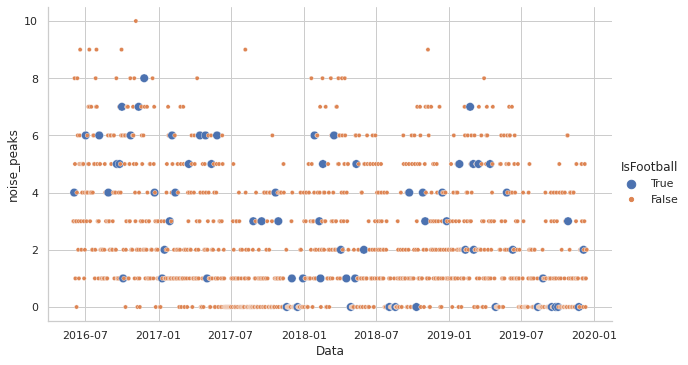

In [79]:
sns.relplot(x="Data", y="noise_peaks", hue="IsFootball", hue_order=[True, False], size_order=[True, False], size="IsFootball", 
            data=df_metrics_football_day, height=5, aspect=1.7);

                 Figure 37 - Number of noise peaks over time versus footbal days

Regarding days with football matches, it is also verified that on most days when there are noise peaks, these two variables are related.

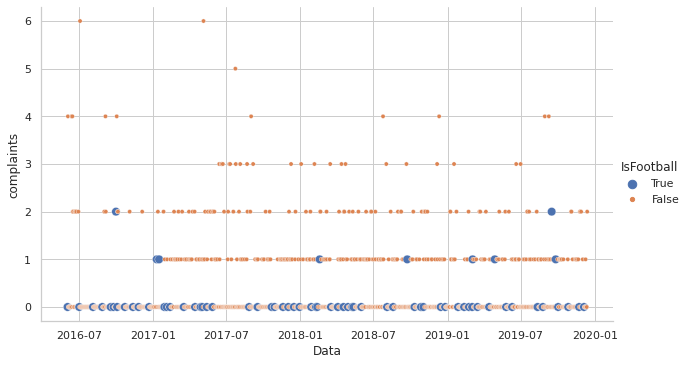

In [80]:
sns.relplot(x="Data", y="complaints", hue="IsFootball", hue_order=[True, False], size_order=[True, False], size="IsFootball", 
            data=df_metrics_football_day, height=5, aspect=1.7);

                 Figure 38 - Number of complaints over time versus footbal days

As for complaints, it appears that the existence of soccer games or not, has no impact on the number of complaints.

#### Combine weekends, holidays, football games into leisure score

The previous analysis allows us to create a new variable taking into account the variables that had an impact on noise peaks. The variables that showed to be related to noise peaks were: weekends, holidays, and soccer games.

Thus, a leisure score system was created in which if it is a holiday, weekend, or soccer day the score is 1, if it is a holiday or weekend and soccer day the score is 2, and if it is not any of these days then the score is 0.

In [81]:
def generate_row_leisure_score(row):
    count=0
    if row.IsHoliday:
        count+=1
        
    if row.IsFootball:
        count+=1
        
    if row.IsWeekend:
        count+=1
    
    return count

# Merge dfs
df_merged=pd.merge(df_metrics_holidays_day, df_metrics_football_day, left_on=["Data"], right_on=["Data"], how='outer')
df_merged=pd.merge(df_merged, df_weekend, left_on=["Data"], right_on=["Data"], how='outer')

df_merged=df_merged[df_merged["Data"].notnull()]
df_merged["leisure_score"]=df_merged.apply(lambda row: generate_row_leisure_score(row), axis=1)

df_leisure_day=df_merged[["Data", "complaints", "noise_peaks", "leisure_score"]]
df_leisure_day.head()

,Data,complaints,noise_peaks,leisure_score
0,2016-06-01,0,3,0
1,2016-06-02,0,3,1
2,2016-06-03,0,4,1
3,2016-06-04,4,8,1
4,2016-06-05,0,5,1


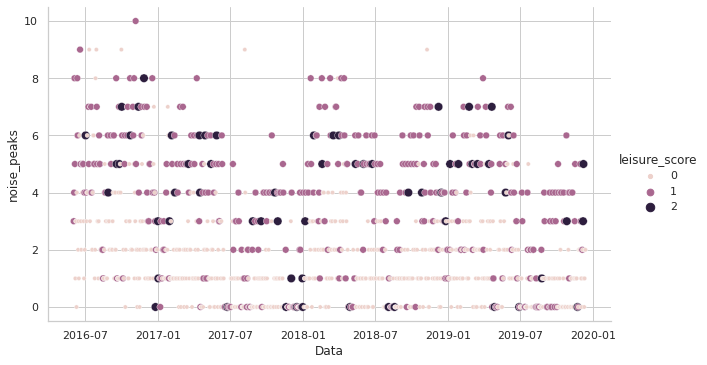

In [82]:
sns.relplot(x="Data", y="noise_peaks", hue="leisure_score", size="leisure_score", 
            data=df_leisure_day, height=5, aspect=1.7);

                 Figure 39 - Number of noise peaks over time versus leisure score

In the previous figure, it can be seen that the lighter pink balls, corresponding to a score of zero, are located for the lower number of noise peaks, while scores of 1 and 2, the darkest pink balls, are for the higher numbers of noise peaks.

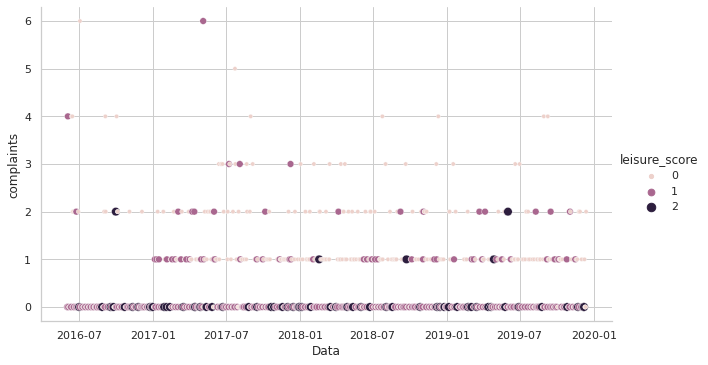

In [83]:
sns.relplot(x="Data", y="complaints", hue="leisure_score", size="leisure_score", 
            data=df_leisure_day, height=5, aspect=1.7);

                 Figure 40 - Number of complaints over time versus leisure score

With complaints there are no patterns.

### Wifi Number of visitors Analysis

We want to analyze the influence on the number of visitors that connect to the city's hotspot and the impact in the noise levels and noise complaints.

In [84]:
df_out = outlier_detection_using_z_score(sensors_df[['C1']], t=1)
 
df_out_max_per_day=df_out.groupby(pd.Grouper(key="date", freq = 'D')).agg({'C1': 'max'})
 

#use only complaints in salvatorio because noise peaks are only from that area 
df_complaints = read_complaints(only_salvario=True)

df_complaints_day=df_complaints.groupby(pd.Grouper(key="Data", freq="D", origin='2016-01-01')).size().reset_index(name='counts').sort_values("Data")

 
df_outlier_day = (df_out.set_index('date')
               .groupby([pd.Grouper(freq = 'D'),'is_outlier'])
               .size()
               .unstack(fill_value=0))
 
    
df_max_peaks_day=pd.merge(df_out_max_per_day, df_outlier_day, left_on="date", right_on="date")[[True, "C1"]].rename(columns={True: "noise_peaks", 'C1':'max_day_peak'})
 

# Merge dfs
df_merged=pd.merge(df_complaints_day, df_max_peaks_day, left_on=["Data"], right_on=["date"], how='inner')
 
df_comp_peaks_day=df_merged[['Data', 'counts', "noise_peaks", "max_day_peak"]].rename(columns={'counts':'complaints'})
 
df_comp_peaks_day

,Data,complaints,noise_peaks,max_day_peak
0,2016-06-01,0,3,69.1
1,2016-06-02,0,3,70.8
2,2016-06-03,0,4,68.4
3,2016-06-04,0,8,71.4
4,2016-06-05,0,5,69.9
...,...,...,...,...
1282,2019-12-05,0,2,67.9
1283,2019-12-06,0,2,66.2
1284,2019-12-07,0,3,70.6
1285,2019-12-08,0,5,69.1


In [85]:
wifi_df = pd.read_csv(base_datasets+'/'+'WIFI Count.csv')
wifi_df['Time'] = pd.to_datetime(wifi_df['Time'])

wifi_df['date'] = [d.date() for d in wifi_df['Time']]
wifi_df['time'] = [d.time() for d in wifi_df['Time']]

wifi_df['date'] = pd.to_datetime(wifi_df['date'])

del wifi_df['Time']

wifi_df.head()

,No. of Visitors,date,time
0,47,2018-10-24,17:00:00
1,155,2018-10-24,18:00:00
2,181,2018-10-24,19:00:00
3,211,2018-10-24,20:00:00
4,239,2018-10-24,21:00:00


In [86]:
#merge wifi data with noise peaks and complaints data
wifi_peaks_complains_df = pd.merge(df_comp_peaks_day, wifi_df, left_on=["Data"], right_on=["date"], how='inner')
del wifi_peaks_complains_df['date']
wifi_peaks_complains_df

,Data,complaints,noise_peaks,max_day_peak,No. of Visitors,time
0,2018-10-24,0,1,66.0,47,17:00:00
1,2018-10-24,0,1,66.0,155,18:00:00
2,2018-10-24,0,1,66.0,181,19:00:00
3,2018-10-24,0,1,66.0,211,20:00:00
4,2018-10-24,0,1,66.0,239,21:00:00
...,...,...,...,...,...,...
1634,2018-12-31,0,2,67.8,158,19:00:00
1635,2018-12-31,0,2,67.8,171,20:00:00
1636,2018-12-31,0,2,67.8,151,21:00:00
1637,2018-12-31,0,2,67.8,125,22:00:00


Data for the number of connected people in the hotspot starts at 2018-10-24 and ends at 2018-12-31

In [87]:
def correlation_matrix (df):
    cor = df.corr()
    
    fig,ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cor, annot=True)

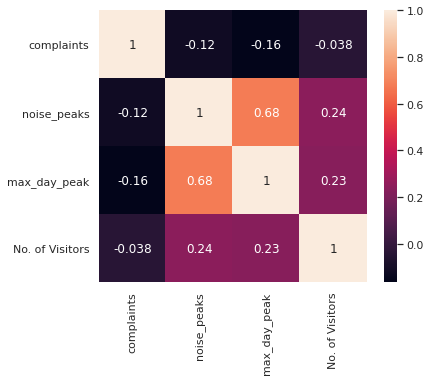

In [88]:
correlation_matrix(wifi_peaks_complains_df)

                 Figure 41 - Correlation matrix with the number of visitors

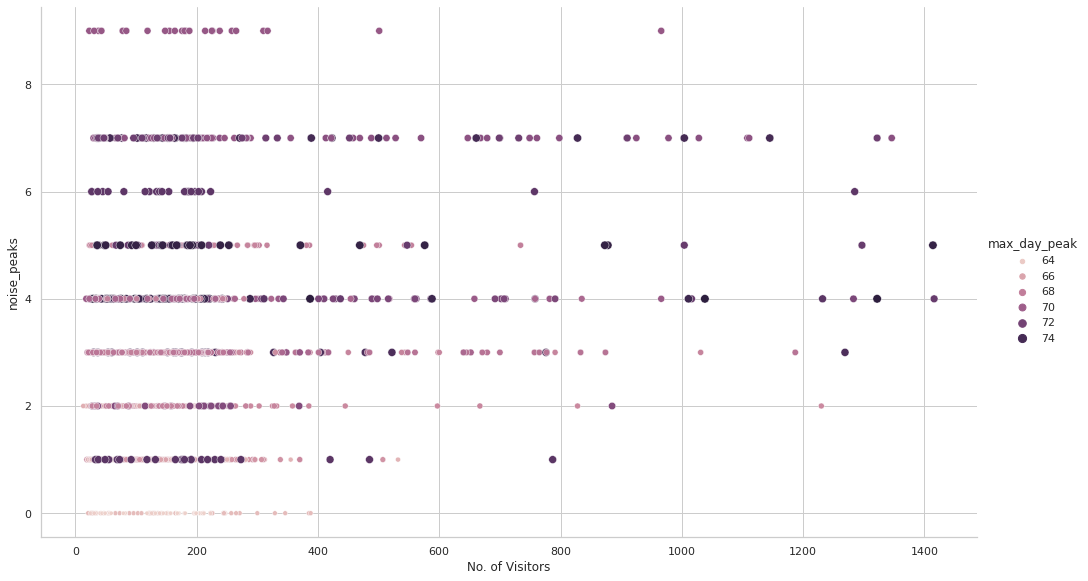

In [89]:
sns.relplot(x="No. of Visitors", y="noise_peaks", hue="max_day_peak", size="max_day_peak", 
            data=wifi_peaks_complains_df, height=5, aspect=1.7);

              Figure 42 - Number of noise peaks versus number of visitors versus the maximum peak 

There seems to be a small correlation between the number of visitors and the noise peaks. However, there are also instances in which less visitorts generate higher peaks of noise.

Let us analyze only the complaints now.

In [90]:
df_complaints = read_complaints(only_salvario=False)
df_complaints_day=df_complaints.groupby(pd.Grouper(key="Data", freq="D", origin='2016-01-01'))\
    .size().reset_index(name='counts').sort_values("Data").rename(columns={'counts':'complaints'})
df_complaints_day['Data'] = pd.to_datetime(df_complaints_day['Data'])
wifi_complains_df = pd.merge(df_complaints_day, wifi_df, left_on=["Data"], right_on=["date"], how='inner')
del wifi_complains_df['date']

wifi_complains_df.head()

,Data,complaints,No. of Visitors,time
0,2018-10-24,0,47,17:00:00
1,2018-10-24,0,155,18:00:00
2,2018-10-24,0,181,19:00:00
3,2018-10-24,0,211,20:00:00
4,2018-10-24,0,239,21:00:00
...,...,...,...,...
1634,2018-12-31,0,158,19:00:00
1635,2018-12-31,0,171,20:00:00
1636,2018-12-31,0,151,21:00:00
1637,2018-12-31,0,125,22:00:00


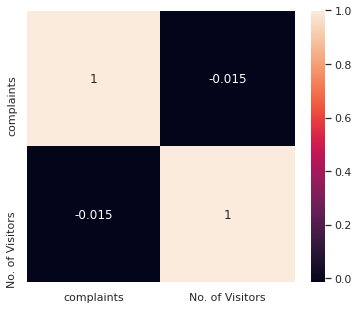

In [91]:
correlation_matrix(wifi_complains_df)

                 Figure 43 - Correlation matrix of complaints versus the number of visitors

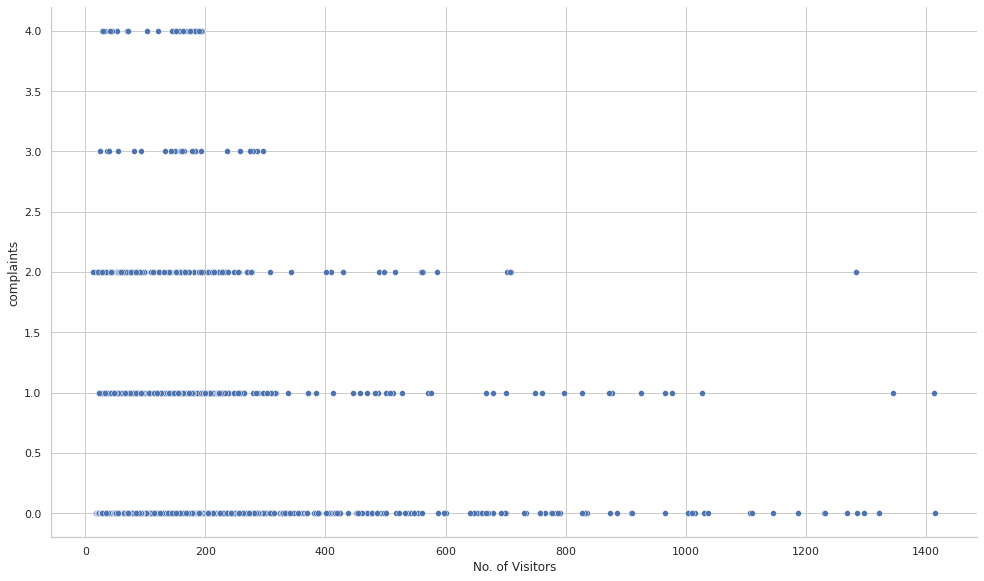

In [92]:
sns.relplot(x="No. of Visitors", y="complaints", data=wifi_complains_df, height=5, aspect=1.7);

                 Figure 44 - Number of complaints versus the number of visitors

This tells us that less visitors generates less noise.
**CONFIRMAR** This offers a contradictory conclusion with the data from SIM cards, as with more people, the more noise was being generated.  
An explanation for this is that not everyone that visits the city connects to the WIFI, as some will use mobile data or not use the inte

# Predict future noise levels

We tried two types of models to predict the number of noise level peaks: statistical methods and deep learning methods. For the statistical methods, we used SARIMAX. For the deep learning methods, we used a Convolutional neural network (CNN). 

Statistical methods are computationally lighter, deterministic, and more explainable. Deep learning methods can detect more complex patterns, patterns that statistical methods don't see, and can handle better missing data and outliers. [23]

## SARIMAX

ARIMA (Autoregressive Integrated Moving Average) is a forecasting method that divides the time series into 3 models (Autoregression+Difference+Moving Average). [21]

SARIMA (Seasonal ARIMA) is similar, but has in consideration the seasonal component of time-series. [21]

SARIMAX (SARIMA with eXogenous regressors model) has in consideration exogenous variables [22].

When using SARIMAX and experimenting with different combinations of parameters if, for example, we assign zero values to the seasonal component and do not use exogenous variables, the ARIMA is obtained. By not only using exogenous variables, is obtained the SARIMA.

In [93]:
def forecasting_with_sarimax(train, test, order, seasonal_order, lags, exog=None):
    mod = sm.tsa.statespace.SARIMAX(train, order=order, seasonal_order=seasonal_order)#, simple_differencing=True)
    res = mod.fit()
    predictions = res.forecast(steps=lags)
    rmse = math.sqrt(mean_squared_error(test, predictions))
    return res.bic, rmse, predictions

lags = 7*4
train = df_outliers_avg[['mean_is_outlier']][:-lags]
test = df_outliers_avg[['mean_is_outlier']][-lags:]

bic, rmse, predictions = forecasting_with_sarimax(train, test, (2,1,0), (1,1,0,12), lags)
print(bic, rmse)

5067.230645622369 1.1705847303547707


In [94]:
from itertools import product

# auxiliar method
# performs a correction on the seasonal parameters of sarimax, the 4th parameter is m
# m represents the period of the time series
def generate_sarima_parameters(combinations, m):
    combination_correction = []
    for t in combinations:
        lst = list(t)
        lst[3] = m
        combination_correction.append(tuple(lst))
    return combination_correction

# generates a list with all combinations of the seasonal parameters of sarimax
def generate_list_with_sarima_parameters(N, m):
    comb_sarima = list(product(range(0, N + 1), repeat = 4))
    combinations_sarima = list(dict.fromkeys(generate_sarima_parameters(comb_sarima, m)))
    #\  + generate_sarima_parameters(comb_sarima, 24*7)
    return combinations_sarima

# performs the sarimax method and creates a dataframe with the results
# Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model
def run_sarimax(train, test, lags, N, m, exog=None):

    combinations_arima = list(product(range(0, N + 1), repeat = 3))
    combinations_sarima = generate_list_with_sarima_parameters(N, m)

    combinations_arima = combinations_arima
    combinations_sarima = combinations_sarima

    df_results = pd.DataFrame(columns=['bic', 'rmse', 'arima', 'sarima'])
    
    print("Combinations: " + str(len(combinations_arima)*len(combinations_sarima)))
    
    i=0

    for c_arima in combinations_arima:
        print(i)
        for c_sarima in combinations_sarima:
            bic, rmse, predictions = forecasting_with_sarimax(train, test, c_arima, c_sarima, lags, exog)
            df_results = df_results.append({'bic':bic, 'rmse': rmse, 'arima':c_arima, 'sarima':c_sarima},\
                                           ignore_index=True)
            i += 1

    return df_results

### Without eXogenous variable

In [95]:
results_sarimax = run_sarimax(train, test, lags, 1, 28) # com 2 demora muito tempo...
results_sarimax.head()

Combinations: 64
0
8
16
24
32
40
48
56


,bic,rmse,arima,sarima
0,6104.777286,1.530639,"(0, 0, 0)","(0, 0, 0, 28)"
1,5608.599145,1.170909,"(0, 0, 0)","(0, 0, 1, 28)"
2,5182.903315,1.280625,"(0, 0, 0)","(0, 1, 0, 28)"
3,4734.286331,0.676275,"(0, 0, 0)","(0, 1, 1, 28)"
4,5159.964996,1.022598,"(0, 0, 0)","(1, 0, 0, 28)"


In [96]:
# best model - using rmse as a metric
results_sarimax.sort_values(by='rmse').head(1)

,bic,rmse,arima,sarima
5,4866.887597,0.662182,"(0, 0, 0)","(1, 0, 1, 28)"


In [97]:
# best model - using bic as a metric
results_sarimax.sort_values(by='bic').head(1)

,bic,rmse,arima,sarima
59,4030.930101,0.781601,"(1, 1, 1)","(0, 1, 1, 28)"


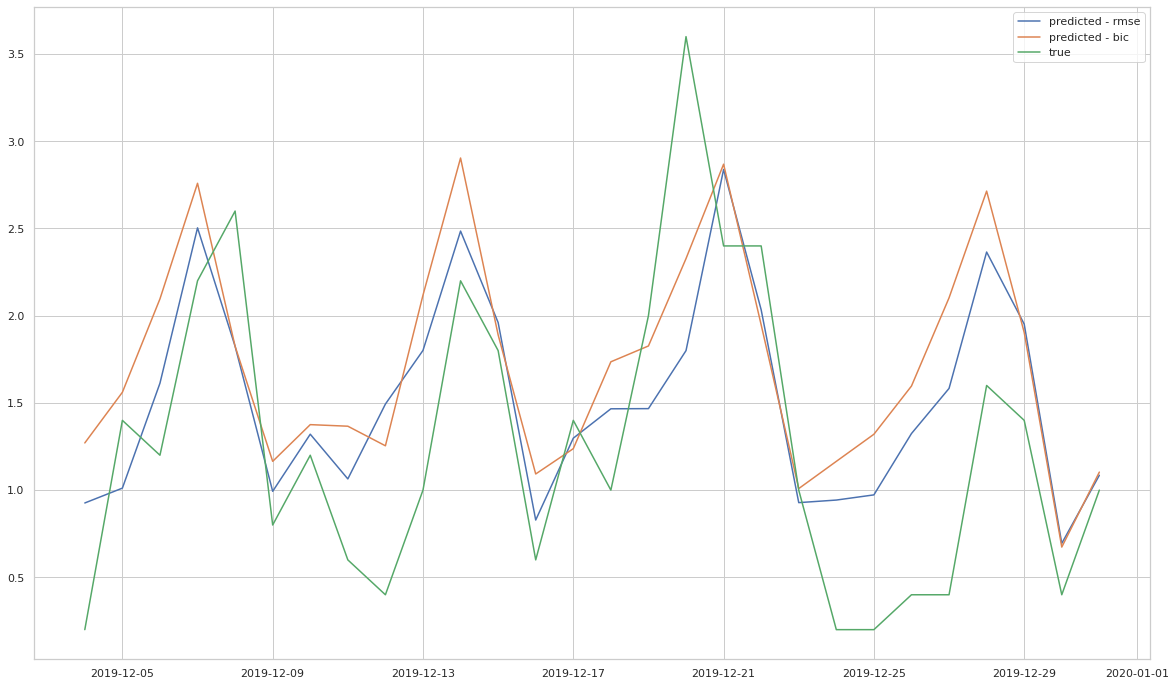

In [98]:
# comparasion on the obtained results

bic, rmse, predictions = forecasting_with_sarimax(train, test, (0, 0, 0), (1, 0, 1, 28), lags)
bic2, rmse2, predictions2 = forecasting_with_sarimax(train, test, (1, 1, 1), (0, 1, 1, 28), lags)

plt.plot(predictions, label='predicted - rmse')
plt.plot(predictions2, label='predicted - bic')
plt.plot(test, label='true')
plt.legend()

                 Figure 45 - Forecasting without SARIMAX withour eXogenous variables

Some considerations:

- when we choose the best model using rmse as a metric, the non-seasonal component (arima) is all zeros, and it only assigns a value to the seasonal component;

- there is a possibility of getting a better method with rmse because it may lead to overfitting. In the case of statistical methods, which is ours, preference is given to metrics such as bic which, when choosing a model, sometimes has greater error but does not cause overfitting;

- in the best model with the bic, the values of the non-seasonal component and the seasonal component have at least one value other than one.

### With with eXogenous variable

In [99]:
exogenous = df_leisure_day[['leisure_score']][:-lags]

In [100]:
results_sarimax = run_sarimax(train, test, lags, 1, 28, exogenous) # com 2 demora muito tempo...
results_sarimax.head()

Combinations: 64
0
8
16
24
32
40
48
56


,bic,rmse,arima,sarima
0,6104.777286,1.530639,"(0, 0, 0)","(0, 0, 0, 28)"
1,5608.599145,1.170909,"(0, 0, 0)","(0, 0, 1, 28)"
2,5182.903315,1.280625,"(0, 0, 0)","(0, 1, 0, 28)"
3,4734.286331,0.676275,"(0, 0, 0)","(0, 1, 1, 28)"
4,5159.964996,1.022598,"(0, 0, 0)","(1, 0, 0, 28)"


In [101]:
# best model - using rmse as a metric
results_sarimax.sort_values(by='rmse').head(1)

,bic,rmse,arima,sarima
5,4866.887597,0.662182,"(0, 0, 0)","(1, 0, 1, 28)"


In [102]:
# best model - using bic as a metric
results_sarimax.sort_values(by='bic').head(1)

,bic,rmse,arima,sarima
59,4030.930101,0.781601,"(1, 1, 1)","(0, 1, 1, 28)"


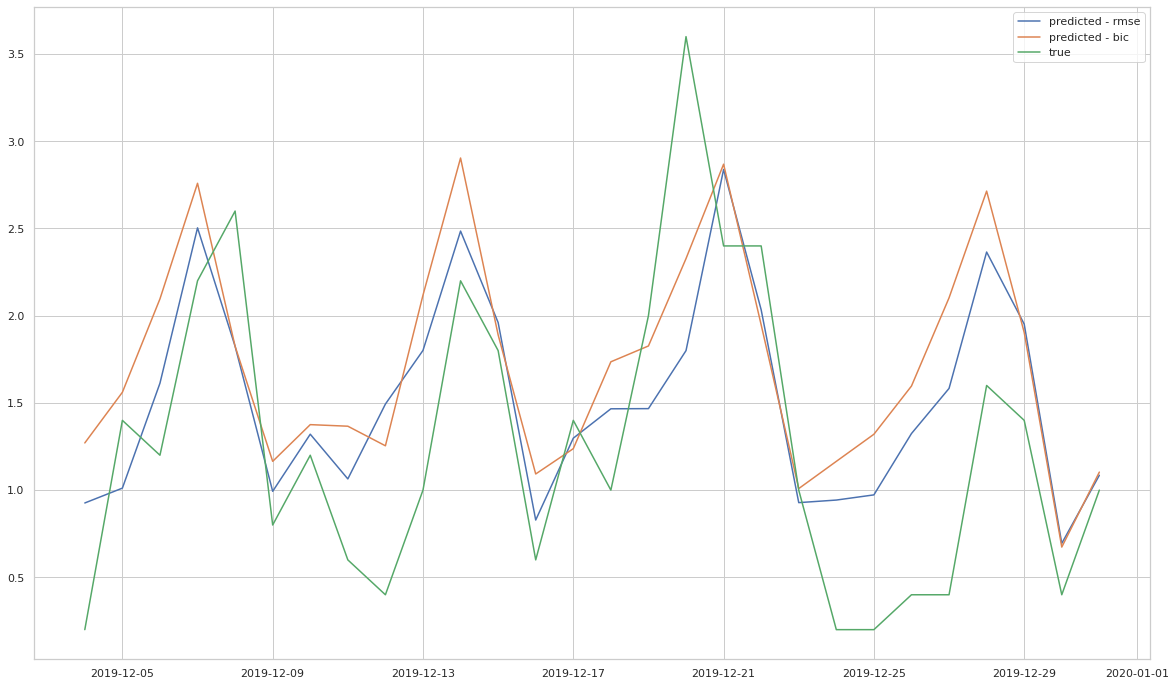

In [103]:
# comparasion on the obtained results

bic, rmse, predictions = forecasting_with_sarimax(train, test, (0, 0, 0), (1, 0, 1, 28), lags, exogenous)
bic2, rmse2, predictions2 = forecasting_with_sarimax(train, test, (1, 1, 1), (0, 1, 1, 28), lags, exogenous)

plt.plot(predictions, label='predicted - rmse')
plt.plot(predictions2, label='predicted - bic')
plt.plot(test, label='true')
plt.legend()

                 Figure 46 - Forecasting with SARIMAX withour eXogenous variables

Using exogenous features did not change the performance of the models, this means that the model did not observe patterns related to the exogenous feature; therefore, our best model is a SARIMA model (only has the non-seasonal and seasonal components).

## Convolutional neural network

There are several types of Artificial Neural Networks (ANN). 

Long short-term memory (LSTM) is a type of recurrent neural network (RNN), designed to deal with sequential data and robust against the vanishing error problem, a common problem in RNN networks. [24]

CNNs are usually used in image classification; however, they proved to be suitable for forecasting, achieving better results than LSTM networks. CNNs are computationally lighter and can handle missing data better. [26]

# Noise-pollution fighting measures

Fighting noise pollution is essential to improve cities' ecosystems. There are several measures that can help to decrease noise, such as planting trees [26] and obligating new commercial buildings to be constructed with materials that insulate noise. However, these measures are not enough because the major factor that leads to noise pollution is human beings.

To combat noise pollution it may also help to identify areas of major noise and implement measures such as, prohibit cars from honking in those areas (schools, universities, hospitals, ...), limit the maximum capacity of people, implement measures to reduce the number of vehicles in circulation and apply laws that reduce excessive noise/maximum number of people in establishments.

However, the measures presented above may not be enough. We need to have proactive measures to help city managers to allocate better the resources available. These proactive measures depend on forecasting accurately the noise expected or the number of people expected. So, city managers can predict when and where, for instance, police should make patrols to control crowds.


# Conclusions

## Scalability and Impact

Primarily, from the analysis of the noise level data for all sensors over the years, considering that it was only used data from 2016 to 2019, the existence of daily, weekly, monthly and annual patterns were found, as a result of the daily lives of people who commute in the city. Through the day, the noise level peaks are found in the morning, possibly a result of people traveling to work and school, and at night and dawn, which can be related to the city's nightlife with people going to pubs and clubs, or even just from conversations on the street in gatherings. Throughout the week, it can be seen that there is an increase in noise levels at the weekend and, throughout the months of the year, there are months when there is a drop in noise levels, namely for January and August.

In addition to the sensor data, the various types of external data provided allowed for a varied analysis and thus to conclude the existence or not of relationships between noise level and the number of people, demographical characteristics, complaints, weather, holidays, weekends, and soccer games.

Regarding complaints, there were no relevant patterns with noise peaks and when analyzing with the other external variables, no relevant patterns were found either. Between noise level and the number of people, it was found that the greater the number of people in the area, the higher the sound levels. Regarding demographic characteristics, it was found that there are three groups that at lower noise levels are represented by fewer people and that at higher levels by more people, that is, the increase in the number of people each of these characteristics is related to the increase in noise level. The groups are males, ages between 18 and 30, and intraregional visitors. With weather data, there were no evident correlations with noise peaks or complaints, only between the weather variables, as expected.

The variables with which patterns with noise peaks were found were the weekends, holidays, and soccer games. When it's a weekend or a holiday or there's a soccer game, there are more noise peaks, which can be a result of more people on the street those days. With these three variables, a new variable was created, leisure score, that was again verified to be related to noise peaks and, for that reason, was one of the starting point variables of the models.

Relativamente à análise gráfica **Adicionar resumo da parte do Bruno**

In our solution, we used SARIMAX and CNN to predict the mean number of noise peaks per day. In the case of SARIMAX, the use of external variables did not increase the performance of the model, so only the seasonal and non-seasonal components of the data were considered. As for CNN, the same was found, that the external variable is not as important as the mean number of noise peaks of the previous week. Thus, it was concluded that the external variable that, from the EDA was more related to the noise peaks, when used by the models, does not increase the model's prediction capacity.

The results obtained from our solution can benefit the local administration to draw some policies. In terms of number of people, recalling that from 65 dB onwards it is considered noise pollution, the busy areas may be limited  (…)

Detecting high peaks and, as a consequence, applying the polices that lead to the reduction of noise levels is very important and increases the quality of life of the urban population by reducing the negative effect of excess noise on people's physiology and psychological state.

## Future Work

To improve and make our model more useful, it could also predict the mean number of noise peaks per day and also per hour. Despite having verified at which times the noise level is higher, hourly prediction can help local authorities to apply measures more effectively.

Through the analysis of the number of people and demographic characteristics, it was found that there are higher noise levels with the increase of some groups. The analysis performed only corresponded to 3 weeks of 2018, which limits its use. An example of future work could be to obtain this type of information for more days of the year and thus incorporate it into our solution’s models.


# References

[1]	W. Davies, P. Hepworth, A. Moorhouse, and R. Oldfield, “Noise from Pubs and Clubs Phase I,” Contract, no. October, 2005. Available: http://scholar.google.com/scholar?hl=en&btnG=Search&q=intitle:Noise+from+Pubs+and+Clubs+Phase+I#0.

[2]	Y. Nakane, M. Tazaki, and E. Miyaoka, “Whoqol,” Iryo To Shakai, vol. 9, no. 1, pp. 123–131, 1999, doi: 10.4091/iken1991.9.1_123.

[3]	European Environment Agency, Environmental noise in Europe - 2020, no. 22/2019. 2020.

[4]	World Health Organization, “WHO night noise guidelines for Europe.” https://www.euro.who.int/en/health-topics/environment-and-health/noise/policy/who-night-noise-guidelines-for-europe.

[5]	“Noise pollution: how to reduce the impact of an invisible threat?” https://www.iberdrola.com/environment/what-is-noise-pollution-causes-effects-solutions.

[6]	E. Gallo and L. Shtrepi, “Long term monitoring of noise pollution in social gatherings places: Time analysis and acoustic capacity as support of management strategies,” Proc. Int. Congr. Acoust., vol. 2019-Septe, no. September, pp. 333–340, 2019, doi: 10.18154/RWTH-CONV-239494.

[7]	E. Gallo, E. Ciarlo, M. Santa, E. Sposato, B. Vincent, and Y. Halbwachs, “Analysis of leisure noise levels and assessment of policies impact in San Salvario district , Torino ( Italy ), by low-cost IoT noise monitoring network,” pp. 699–704, 2018.

[8]	“Autocorrelation.” https://otexts.com/fpp2/autocorrelation.html.

[9]    “Z-Score: Definition, Formula and Calculation.” https://www.statisticshowto.com/probability-and-statistics/z-score/.

[10]    “Median Absolute Deviation.” https://www.statisticshowto.com/median-absolute-deviation/.

[11]    “Identifying outliers with the 1.5xIQR rule.” https://www.khanacademy.org/math/statistics-probability/summarizing-quantitative-data/box-whisker-plots/a/identifying-outliers-iqr-rule.


[21]	“A Gentle Introduction to SARIMA for Time Series Forecasting in Python.” https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

[22] "SARIMAX" https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

[23] M.G. Karlaftis, E.I. Vlahogianni, "Statistical methods versus neural networks in transportation research: Differences, similarities and some insights", Transportation Research Part C: Emerging Technologies, Volume 19, Issue 3, 2011, Pages 387-399, ISSN 0968-090X, https://doi.org/10.1016/j.trc.2010.10.004.

[24] F. A. Gers, J. Schmidhuber and F. Cummins, "Learning to forget: continual prediction with LSTM," 1999 Ninth International Conference on Artificial Neural Networks ICANN 99. (Conf. Publ. No. 470), 1999, pp. 850-855 vol.2, doi: 10.1049/cp:19991218.

[25] Shaojie Bai and J. Zico Kolter and Vladlen Koltun, "An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling", 2018.

[26] "Can Trees Reduce Noise Pollution in Urban Areas?", https://www.conserve-energy-future.com/can-trees-reduce-noise-pollution.php